# Battery Energy Storage Analysis

## **- Charan Kandasamy Raja**

# Imports

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import signal
import xgboost as xgb


In [66]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('BESS_Data.csv')

# Print the head of the DataFrame
print("DataFrame Head:")
print(df.head())

# Print the summary (describe) of the DataFrame
print("\nDataFrame Summary:")
print(df.describe(include='all')) # include='all' includes non-numeric columns


DataFrame Head:
   Day Clock Time BESS SoC 1 BESS SoC 2  Max Power Export [MW]  \
0    1    0:00:00      9.50%     11.60%                  60.53   
1    1    0:10:00      9.50%     11.70%                  53.16   
2    1    0:20:00      9.40%     11.60%                  64.74   
3    1    0:30:00      9.40%     11.50%                  42.89   
4    1    0:40:00      9.40%     11.60%                  42.79   

   Max Power Import [MW]  Max Temp (degrees C)  Min Temp (degrees C)  \
0                  90.53                  49.3                   9.1   
1                  89.47                  49.6                   9.1   
2                  89.47                  49.2                   9.1   
3                  89.47                  49.1                   9.0   
4                  89.47                  49.0                   9.0   

   Power [MW]  
0       -0.30  
1       -0.71  
2        2.85  
3       -0.92  
4       -0.87  

DataFrame Summary:
               Day Clock Time BESS SoC

# Cleaning

**Identified two missing rows with no data**

In [67]:
df['Timestamp'] = df.apply(lambda row: pd.to_datetime(f"2024-01-{int(row['Day'])} {row['Clock Time']}"), axis=1)
df = df.set_index('Timestamp') # Keep Clock Time for now to show it gets filled

# Re-index the dataframe with a complete 10-minute frequency index
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='10min')
df_reindexed = df.reindex(full_index)

# --- Interpolation ---
# Use the interpolate method. 'linear' is the default and works well for time-series.
df_filled = df_reindexed.interpolate(method='linear')

# --- Verification ---
print("Data around the gap before filling (contains NaN):")
print(df_reindexed.loc['2024-01-03 14:00:00':'2024-01-03 14:30:00'])


Data around the gap before filling (contains NaN):
                     Day Clock Time BESS SoC 1 BESS SoC 2  \
2024-01-03 14:00:00  3.0   14:00:00     73.40%     79.00%   
2024-01-03 14:10:00  NaN        NaN        NaN        NaN   
2024-01-03 14:20:00  NaN        NaN        NaN        NaN   
2024-01-03 14:30:00  3.0   14:30:00     73.50%     79.00%   

                     Max Power Export [MW]  Max Power Import [MW]  \
2024-01-03 14:00:00                  97.37                  78.42   
2024-01-03 14:10:00                    NaN                    NaN   
2024-01-03 14:20:00                    NaN                    NaN   
2024-01-03 14:30:00                  98.42                  77.89   

                     Max Temp (degrees C)  Min Temp (degrees C)  Power [MW]  
2024-01-03 14:00:00                  45.2                  10.0       -0.17  
2024-01-03 14:10:00                   NaN                   NaN         NaN  
2024-01-03 14:20:00                   NaN                   NaN

In [68]:
# Function to fill 'Clock Time' based on the timestamp index
def get_clock_time_from_index(timestamp):
    return timestamp.strftime('%H:%M:%S')

# Apply the function to fill the 'Clock Time' column for the reindexed DataFrame
df_filled['Clock Time'] = df_filled.index.to_series().apply(get_clock_time_from_index)


# prompt: Fill in BESS SoC 1 ,BESS SoC 2 valuesfor the 2 filled in rows with the previous times values

# For 'BESS SoC 1' and 'BESS SoC 2', fill missing values with the previous non-NaN value
# Use fillna with the 'ffill' method (forward fill)
df_filled['BESS SoC 1'] = df_filled['BESS SoC 1'].fillna(method='ffill')
df_filled['BESS SoC 2'] = df_filled['BESS SoC 2'].fillna(method='ffill')

# --- Verification for BESS SoC columns ---
print("\nData around the gap AFTER filling BESS SoC with ffill:")
print(df_filled.loc['2024-01-03 14:00:00':'2024-01-03 14:30:00'])



Data around the gap AFTER filling BESS SoC with ffill:
                     Day Clock Time BESS SoC 1 BESS SoC 2  \
2024-01-03 14:00:00  3.0   14:00:00     73.40%     79.00%   
2024-01-03 14:10:00  3.0   14:10:00     73.40%     79.00%   
2024-01-03 14:20:00  3.0   14:20:00     73.40%     79.00%   
2024-01-03 14:30:00  3.0   14:30:00     73.50%     79.00%   

                     Max Power Export [MW]  Max Power Import [MW]  \
2024-01-03 14:00:00                  97.37              78.420000   
2024-01-03 14:10:00                  97.72              78.243333   
2024-01-03 14:20:00                  98.07              78.066667   
2024-01-03 14:30:00                  98.42              77.890000   

                     Max Temp (degrees C)  Min Temp (degrees C)  Power [MW]  
2024-01-03 14:00:00                  45.2                  10.0   -0.170000  
2024-01-03 14:10:00                  45.3                  10.0   -2.903333  
2024-01-03 14:20:00                  45.4                 

In [69]:
df=df_filled

**Handled two other rows with missing BESS SoC 1 value.** Created: *Avg SoC, delta_SoC, Power_MW*

###  Key Calculations

---

#### 1. Average State of Charge (SoC)

$$
\text{Avg SoC}_i = \frac{\text{SoC_clean_1}_i + \text{BESS SoC 2}_i}{2}
$$

---

#### 2. Energy Throughput per Interval

Each interval is 10 minutes (i.e., 1/6 hour):

$$
\text{Power_MW}_i = - \text{Power_MW}_i
$$
(To follow the conventions as specified in the ReadMe)

$$
\text{Energy_MWh}_i = \text{Power_MW}_i \times \frac{1}{6}
$$

---

#### 3. Change in State of Charge (ΔSoC)

$$
\Delta \text{SoC}_i = \text{Avg SoC}_i - \text{Avg SoC}_{i-1}
$$

or simply:

$$
\Delta \text{SoC}_i = \text{diff}(\text{Avg SoC})
$$

In [70]:
# Clean and convert SoC columns
for col in ['BESS SoC 1', 'BESS SoC 2']:
    df[col] = df[col].str.replace('%', '').astype(float) / 100.0

df['SoC_clean_1'] = np.where(df['BESS SoC 1'] == 0, df['BESS SoC 2'], df['BESS SoC 1'])
df['Avg SoC'] = df[['SoC_clean_1', 'BESS SoC 2']].mean(axis=1)

#  Rename columns for easier access
df.rename(columns={
    'Max Power Export [MW]': 'MaxPowerExport_MW',
    'Max Power Import [MW]': 'MaxPowerImport_MW',
    'Max Temp (degrees C)': 'MaxTemp_C',
    'Min Temp (degrees C)': 'MinTemp_C',
    'Power [MW]': 'Power_MW'
}, inplace=True)

# Calculate energy throughput for each interval (10 min = 1/6 hour) Energy = Power * Time

df['Power_MW'] = - df['Power_MW']
df['Energy_MWh'] = df['Power_MW'] * (1 / 6)


#Calculate delta_SoC for each step
df['delta_SoC'] = df['Avg SoC'].diff()


In [71]:
print("\nCleaned Data Head:")
print(df.head())
print("\n Length of df:")
print(len(df))


Cleaned Data Head:
                     Day Clock Time  BESS SoC 1  BESS SoC 2  \
2024-01-01 00:00:00  1.0   00:00:00       0.095       0.116   
2024-01-01 00:10:00  1.0   00:10:00       0.095       0.117   
2024-01-01 00:20:00  1.0   00:20:00       0.094       0.116   
2024-01-01 00:30:00  1.0   00:30:00       0.094       0.115   
2024-01-01 00:40:00  1.0   00:40:00       0.094       0.116   

                     MaxPowerExport_MW  MaxPowerImport_MW  MaxTemp_C  \
2024-01-01 00:00:00              60.53              90.53       49.3   
2024-01-01 00:10:00              53.16              89.47       49.6   
2024-01-01 00:20:00              64.74              89.47       49.2   
2024-01-01 00:30:00              42.89              89.47       49.1   
2024-01-01 00:40:00              42.79              89.47       49.0   

                     MinTemp_C  Power_MW  SoC_clean_1  Avg SoC  Energy_MWh  \
2024-01-01 00:00:00        9.1      0.30        0.095   0.1055    0.050000   
2024-01-01 0

In [72]:
df.fillna(0, inplace=True)

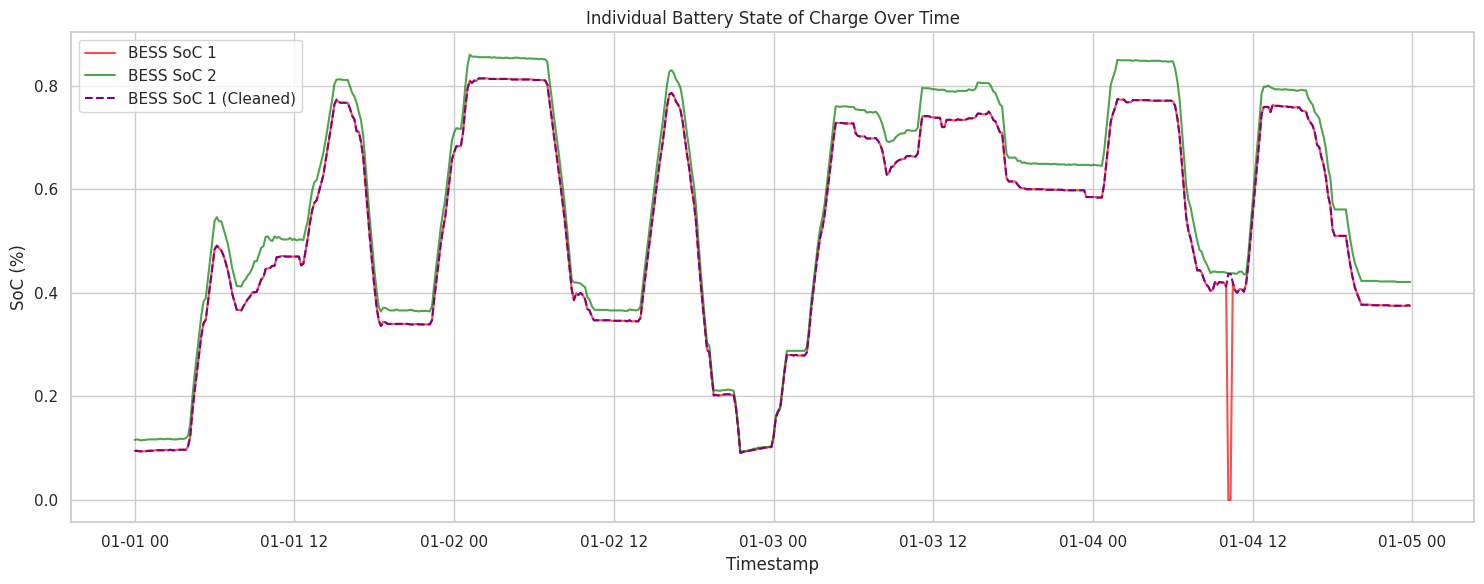

In [73]:
import matplotlib.pyplot as plt


# You could also plot individual SoCs to see the anomaly
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['BESS SoC 1'], label='BESS SoC 1', color='red', alpha=0.7)
plt.plot(df.index, df['BESS SoC 2'], label='BESS SoC 2', color='green', alpha=0.7)
plt.plot(df.index, df['SoC_clean_1'], label='BESS SoC 1 (Cleaned)', color='purple', linestyle='--')
plt.title('Individual Battery State of Charge Over Time')
plt.xlabel('Timestamp')
plt.ylabel('SoC (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [74]:
df.to_csv('cleaned_bess_data.csv')

# EDA

## Power Signal Filtering

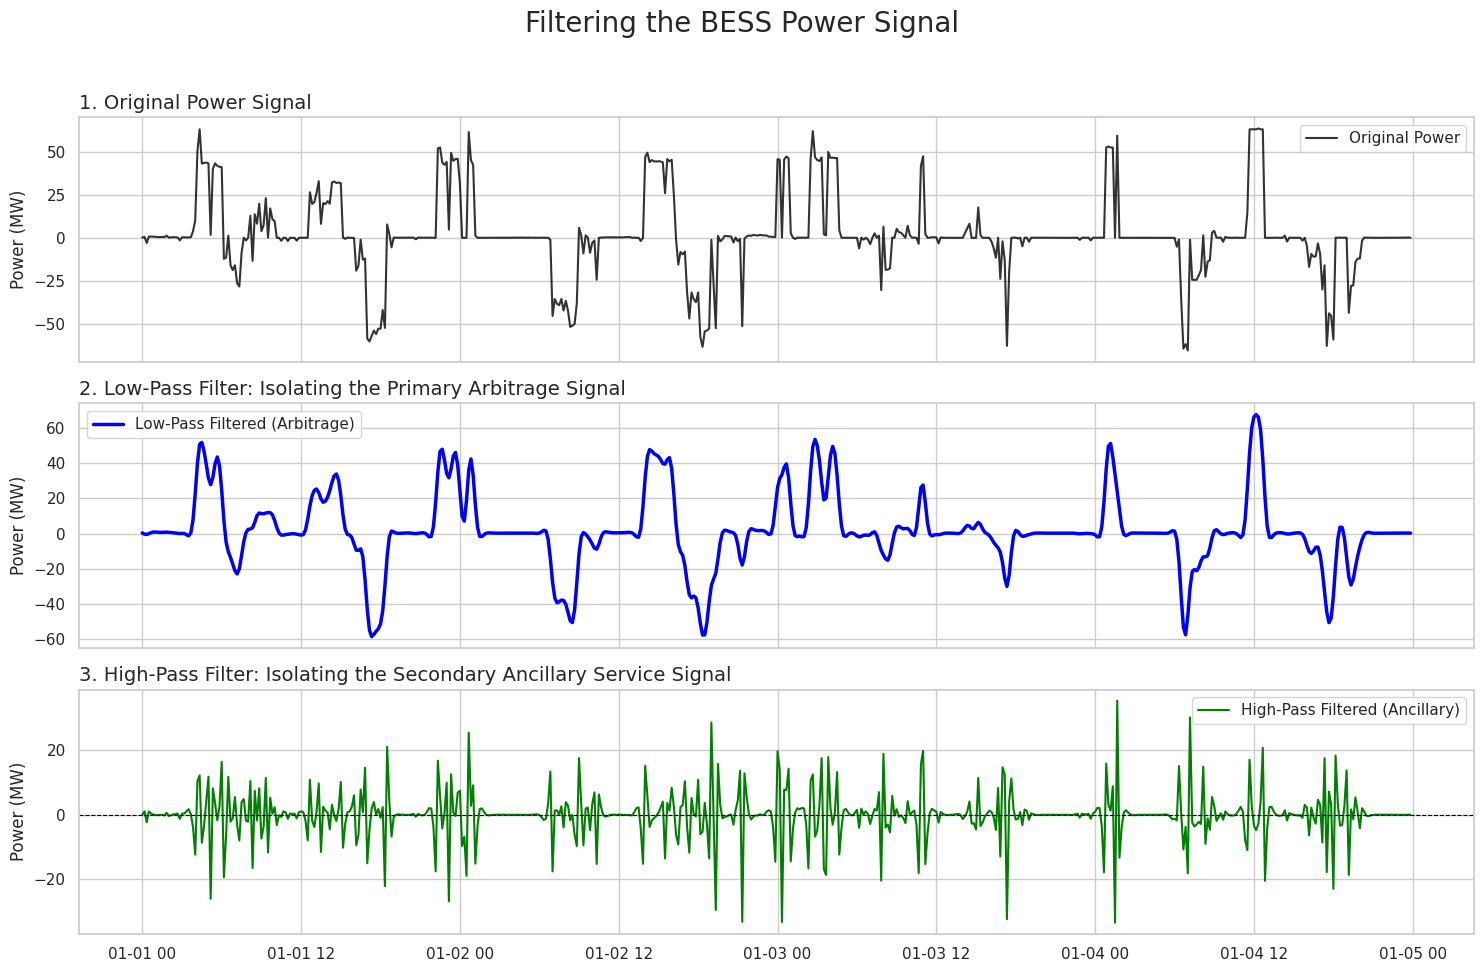

In [75]:
# 1. Define Filter Parameters
#  data is sampled every 10 minutes (600 seconds)
sampling_rate = 1 / 600  # in Hz
# We want to separate signals with periods longer than ~2 hours from those shorter.
# A 2-hour period corresponds to a cutoff frequency.
cutoff_frequency = 1 / (2 * 1800)  # in Hz, for a 2-hour period
nyquist_frequency = 0.5 * sampling_rate
# Normalize the cutoff frequency
normalized_cutoff = cutoff_frequency / nyquist_frequency
filter_order = 2 # The order of the filter

# 2. Design the Filters
# b, a are the filter coefficients
b_low, a_low = signal.butter(filter_order, normalized_cutoff, btype='low', analog=False)
b_high, a_high = signal.butter(filter_order, normalized_cutoff, btype='high', analog=False)

# 3. Apply the Filters
# We use 'filtfilt' to apply the filter forward and backward, which prevents phase shift.
df['Power_LowPass'] = signal.filtfilt(b_low, a_low, df['Power_MW'])
df['Power_HighPass'] = signal.filtfilt(b_high, a_high, df['Power_MW'])


fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
sns.set_style("whitegrid")

# Plot 1: Original Power Signal
axes[0].plot(df.index, df['Power_MW'], label='Original Power', color='black', alpha=0.8)
axes[0].set_title('1. Original Power Signal', fontsize=14, loc='left')
axes[0].set_ylabel('Power (MW)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Low-Pass Filtered Signal (Arbitrage)
axes[1].plot(df.index, df['Power_LowPass'], label='Low-Pass Filtered (Arbitrage)', color='blue', linewidth=2.5)
axes[1].set_title('2. Low-Pass Filter: Isolating the Primary Arbitrage Signal', fontsize=14, loc='left')
axes[1].set_ylabel('Power (MW)')
axes[1].legend()
axes[1].grid(True)

# Plot 3: High-Pass Filtered Signal (Ancillary Services)
axes[2].plot(df.index, df['Power_HighPass'], label='High-Pass Filtered (Ancillary)', color='green', linewidth=1.5)
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[2].set_title('3. High-Pass Filter: Isolating the Secondary Ancillary Service Signal', fontsize=14, loc='left')
axes[2].set_ylabel('Power (MW)')
axes[2].legend()
axes[2].grid(True)

fig.suptitle('Filtering the BESS Power Signal', fontsize=20, y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

df.drop('Power_HighPass', axis=1, inplace=True)
df.drop('Power_LowPass', axis=1, inplace=True)

##  SoC Signal Decomposition

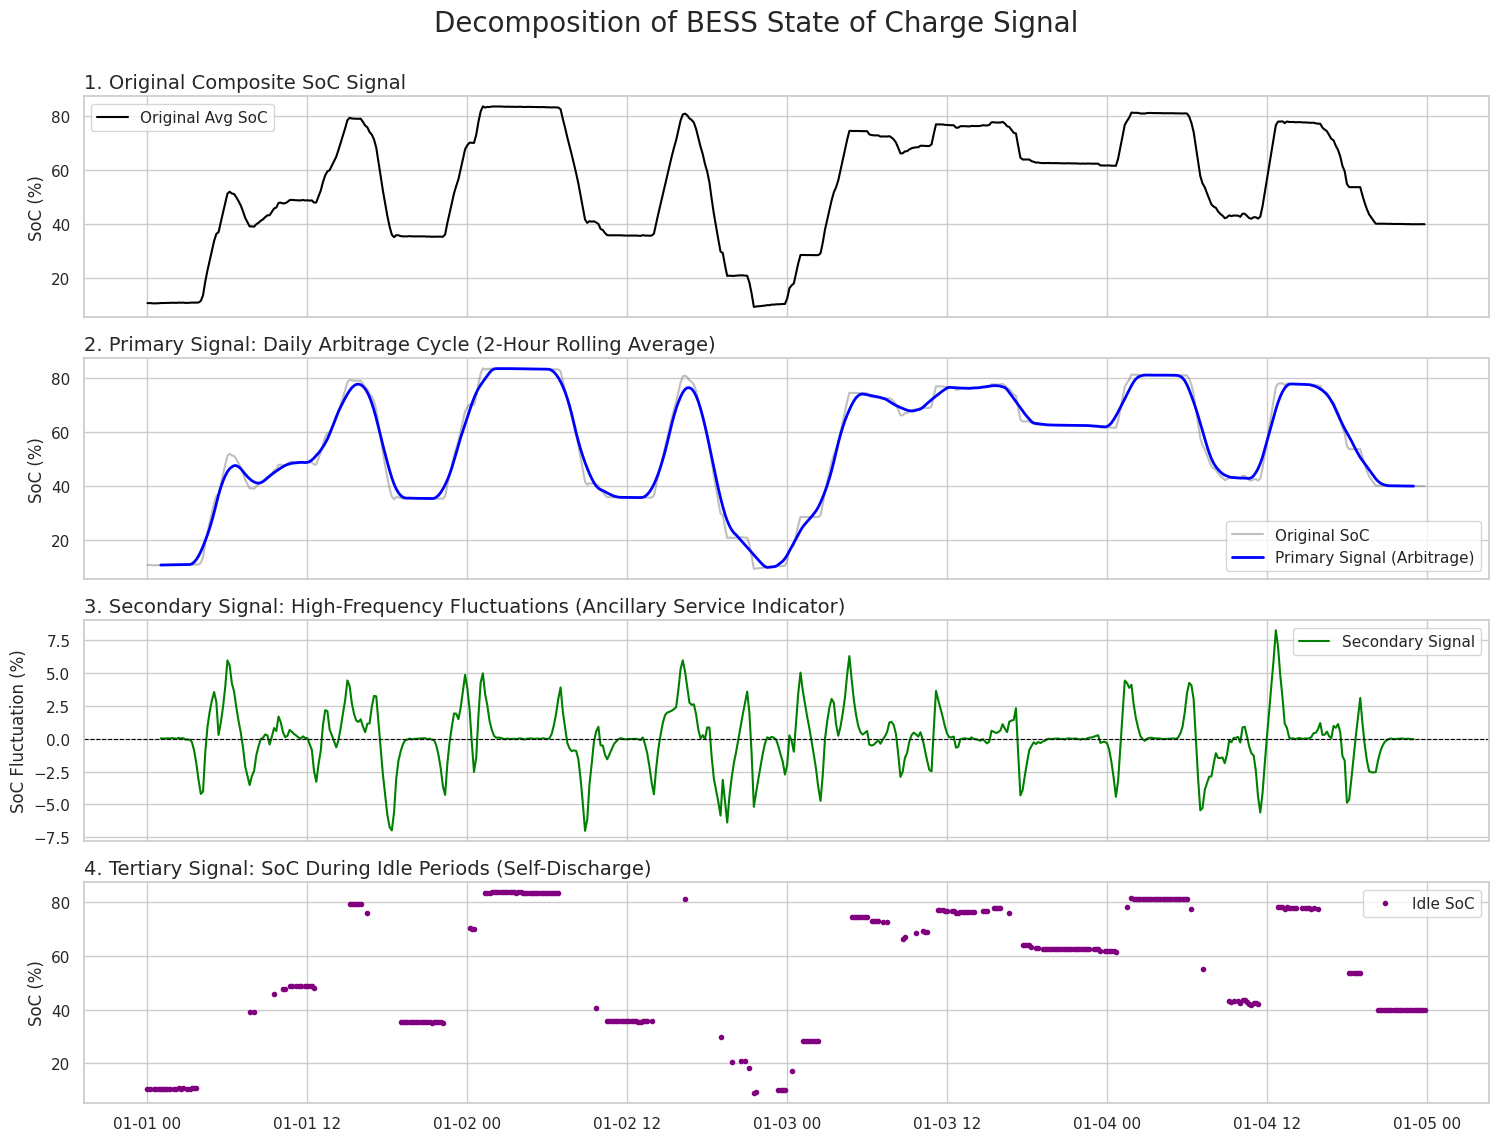

In [76]:
# 1. Primary Signal (Arbitrage Strategy) - Use a 2-hour rolling average to smooth out fluctuations
df['SoC_Primary_Signal'] = df['Avg SoC'].rolling(window=12, center=True).mean()

# 2. Secondary Signal (Ancillary Services) - The residual after subtracting the primary signal
df['SoC_Secondary_Signal'] = df['Avg SoC'] - df['SoC_Primary_Signal']

# 3. Tertiary Signal (Idle State / Self-Discharge) - Identify periods where power is near zero
idle_periods = df[df['Power_MW'].abs() < 1.0]


# --- Visualization ---
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
sns.set_style("whitegrid")

# Plot 1: The Original SoC Signal
axes[0].plot(df.index, df['Avg SoC'] * 100, label='Original Avg SoC', color='black')
axes[0].set_title('1. Original Composite SoC Signal', fontsize=14, loc='left')
axes[0].set_ylabel('SoC (%)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Primary Signal (Arbitrage Trend)
axes[1].plot(df.index, df['Avg SoC'] * 100, label='Original SoC', color='gray', alpha=0.5)
axes[1].plot(df.index, df['SoC_Primary_Signal'] * 100, label='Primary Signal (Arbitrage)', color='blue', linewidth=2)
axes[1].set_title('2. Primary Signal: Daily Arbitrage Cycle (2-Hour Rolling Average)', fontsize=14, loc='left')
axes[1].set_ylabel('SoC (%)')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Secondary Signal (High-Frequency Fluctuations)
axes[2].plot(df.index, df['SoC_Secondary_Signal'] * 100, label='Secondary Signal', color='green')
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[2].set_title('3. Secondary Signal: High-Frequency Fluctuations (Ancillary Service Indicator)', fontsize=14, loc='left')
axes[2].set_ylabel('SoC Fluctuation (%)')
axes[2].legend()
axes[2].grid(True)

# Plot 4: Tertiary Signal (Self-Discharge during Idle Periods)
axes[3].plot(idle_periods.index, idle_periods['Avg SoC'] * 100, label='Idle SoC', color='purple', linestyle='none', marker='.')
axes[3].set_title('4. Tertiary Signal: SoC During Idle Periods (Self-Discharge)', fontsize=14, loc='left')
axes[3].set_ylabel('SoC (%)')
axes[3].legend()
axes[3].grid(True)

fig.suptitle('Decomposition of BESS State of Charge Signal', fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

df.drop('SoC_Primary_Signal', axis=1, inplace=True)
df.drop('SoC_Secondary_Signal', axis=1, inplace=True)

In [77]:
df['Cumulative_Energy_MWh'] = df['Energy_MWh'].cumsum()
print(df['Cumulative_Energy_MWh'].max())

235.69333333333336


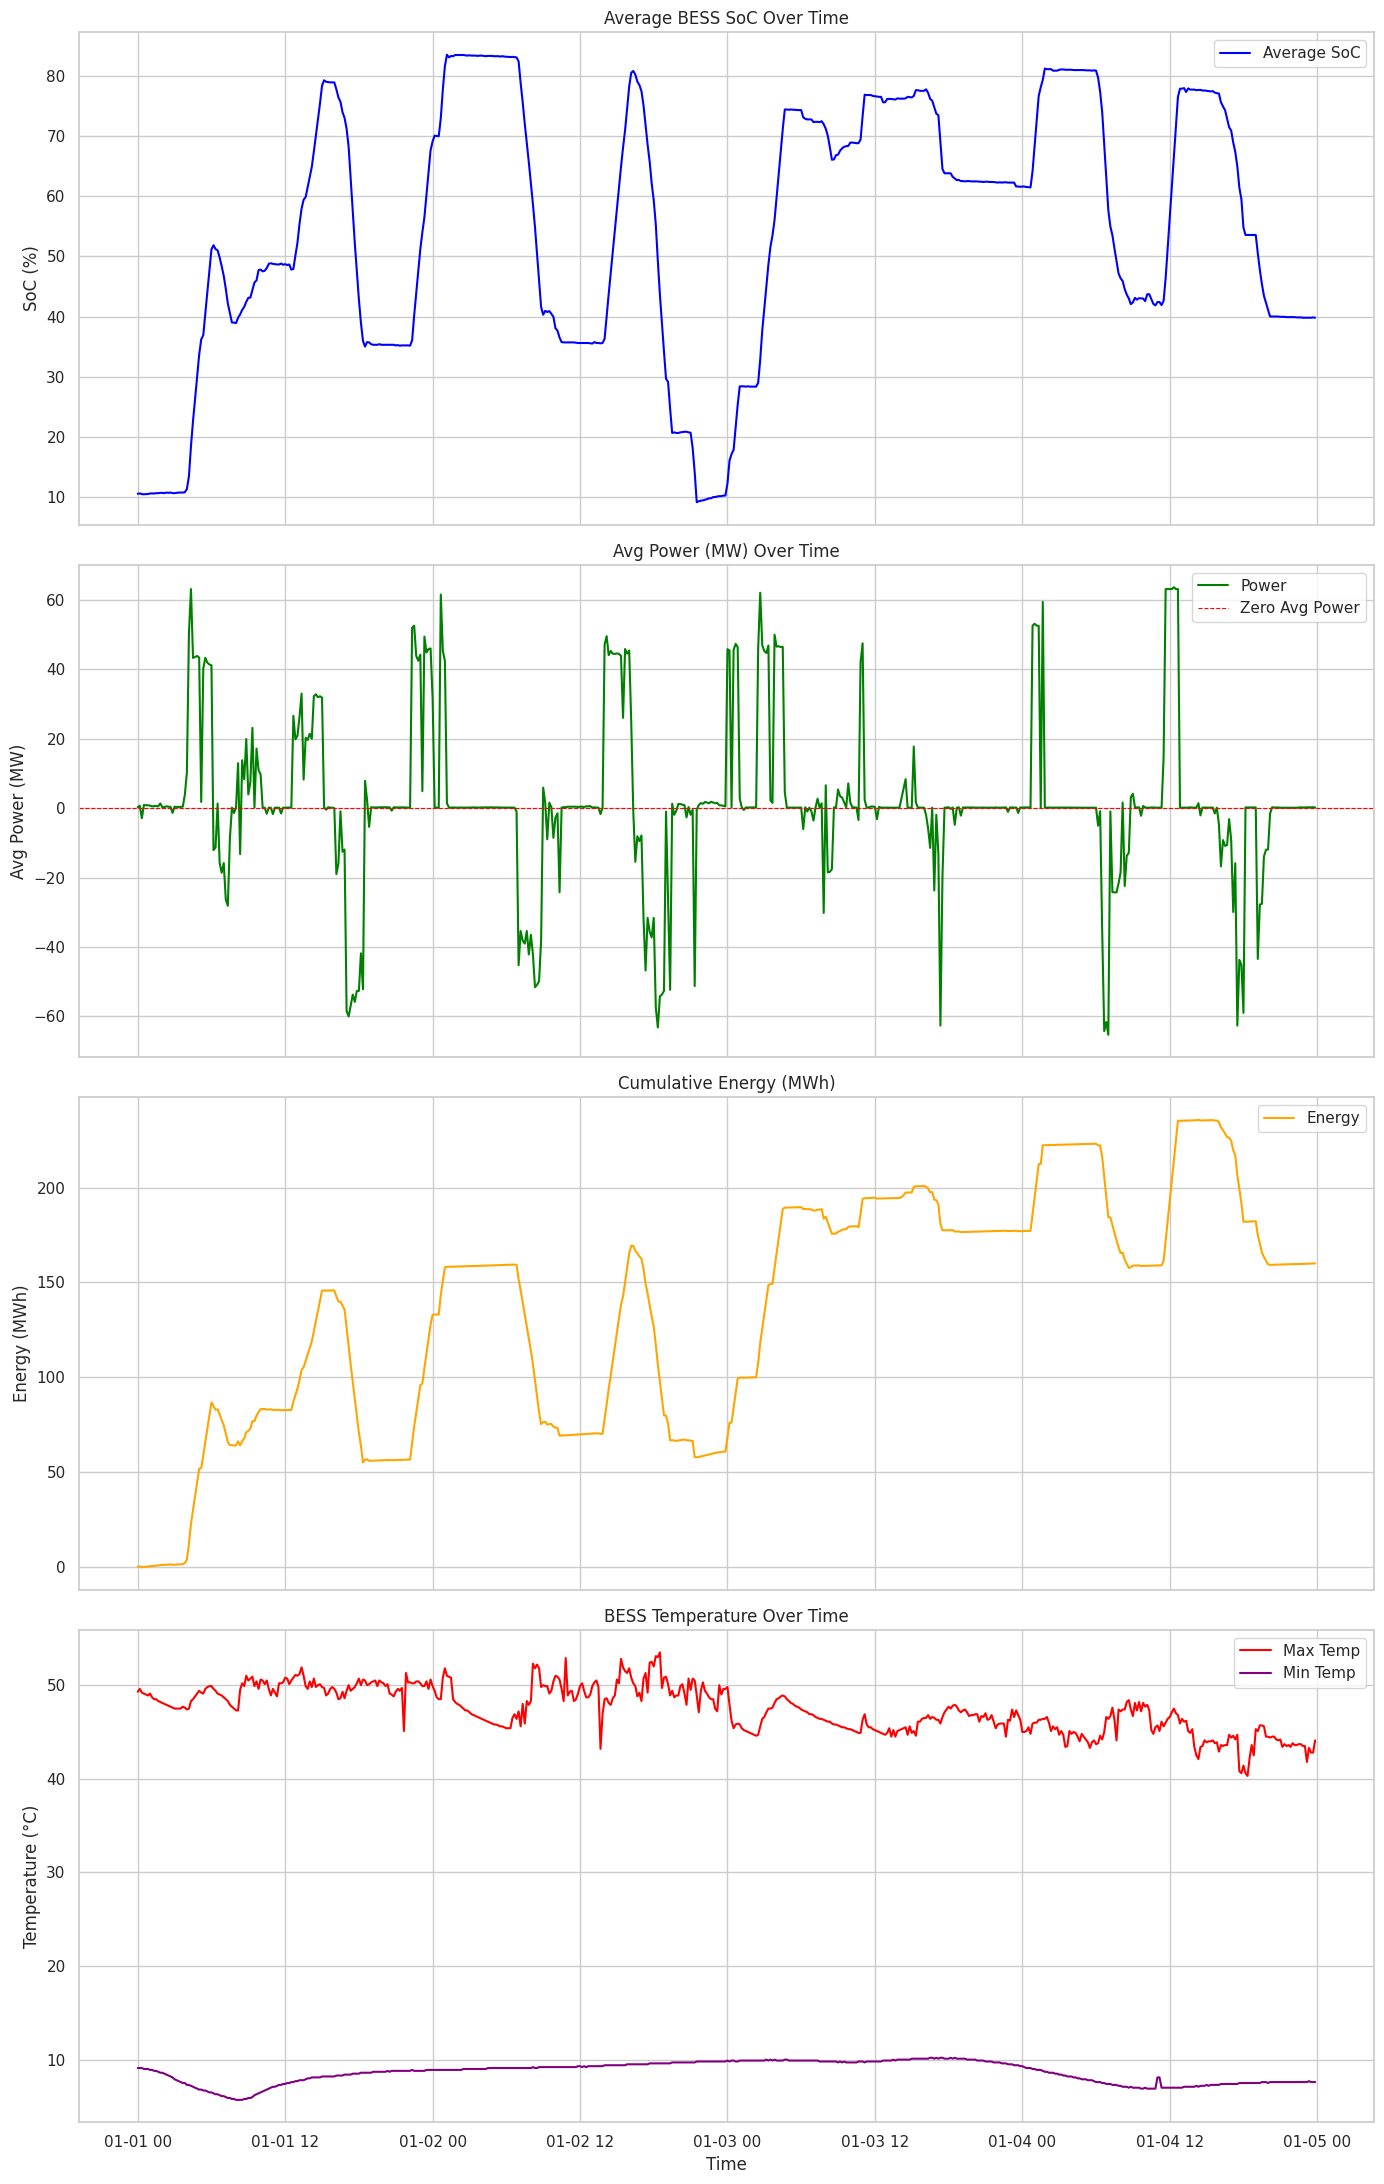

In [78]:
fig, axes = plt.subplots(4, 1, figsize=(14, 22), sharex=True)

# Average SoC over time
axes[0].plot(df.index, df['Avg SoC'] * 100, label='Average SoC', color='blue') # Scaled to percentage
axes[0].set_title('Average BESS SoC Over Time')
axes[0].set_ylabel('SoC (%)')
axes[0].legend()
axes[0].grid(True)

# Power over time
axes[1].plot(df.index, df['Power_MW'], label='Power', color='green')
axes[1].set_title('Avg Power (MW) Over Time')
axes[1].set_ylabel('Avg Power (MW)')
axes[1].axhline(0, color='red', linestyle='--', linewidth=0.8, label='Zero Avg Power')
axes[1].legend()
axes[1].grid(True)

# Energy over time
axes[2].plot(df.index, df['Cumulative_Energy_MWh'], label='Energy', color='orange')
axes[2].set_title('Cumulative Energy (MWh)')
axes[2].set_ylabel('Energy (MWh)')
axes[2].legend()
axes[2].grid(True)

# Temperature over time
axes[3].plot(df.index, df['MaxTemp_C'], label='Max Temp', color='red')
axes[3].plot(df.index, df['MinTemp_C'], label='Min Temp', color='purple')
axes[3].set_title('BESS Temperature Over Time')
axes[3].set_ylabel('Temperature (°C)')
axes[3].set_xlabel('Time')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [79]:
# Pick a time window where SoC changed enough (say > 5%)
window = df[df['delta_SoC'].abs() > 0.05].iloc[0:2]  # first two large changes

soc_start = window.iloc[0]['Avg SoC']
soc_end = window.iloc[1]['Avg SoC']
e_start = window.iloc[0]['Cumulative_Energy_MWh']
e_end = window.iloc[1]['Cumulative_Energy_MWh']

# Energy change in MWh
delta_energy = e_end - e_start
delta_soc = soc_end - soc_start

# Estimate rated capacity
rated_capacity_est = delta_energy / delta_soc if delta_soc != 0 else np.nan
rated_capacity_est

np.float64(188.5751781027373)

## Cumulative Energy vs SoC

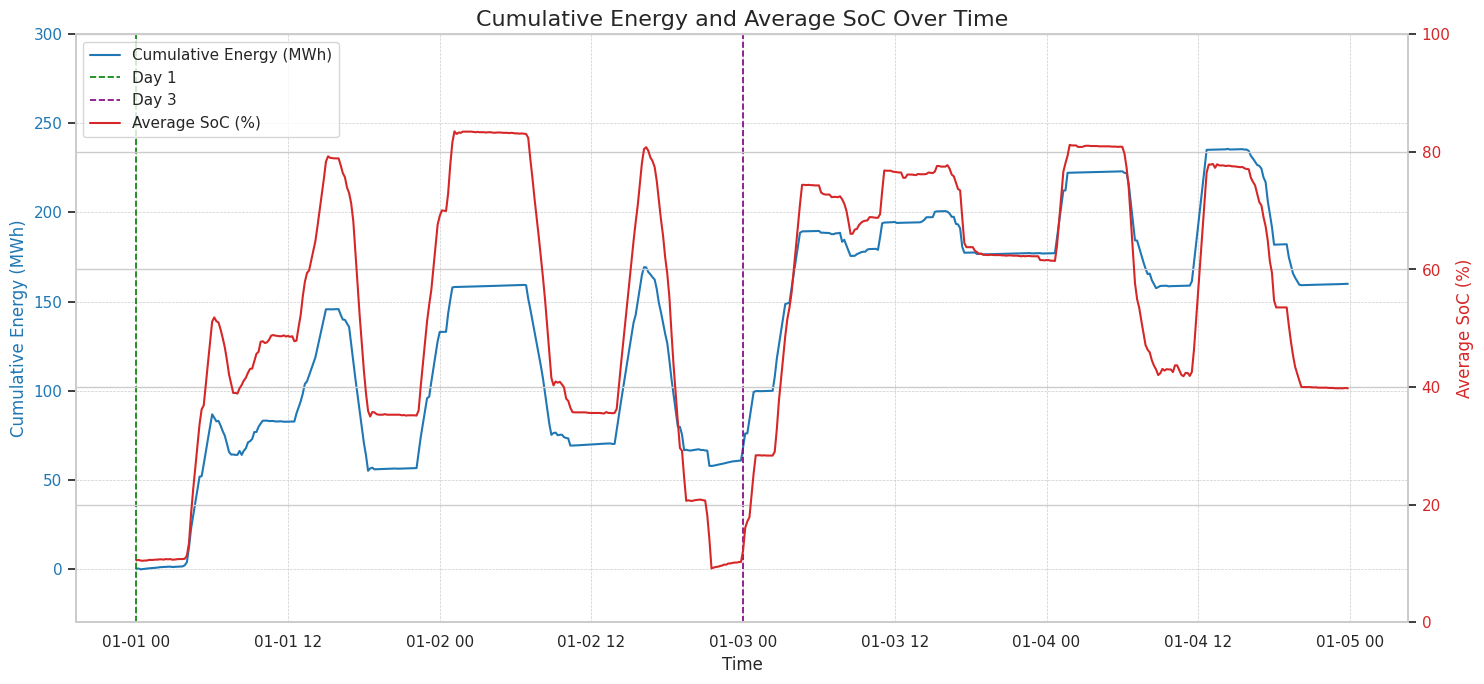

In [80]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Cumulative Energy on the first y-axis
ax1.plot(df.index, df['Cumulative_Energy_MWh'], color='tab:blue', label='Cumulative Energy (MWh)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Energy (MWh)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.set_ylim(-30, 300)

ax1.axvline(pd.Timestamp('2024-01-01'), color='green', linestyle='--', linewidth=1.2, label='Day 1')
ax1.axvline(pd.Timestamp('2024-01-03'), color='purple', linestyle='--', linewidth=1.2, label='Day 3')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot Avg SoC on the second y-axis
ax2.plot(df.index, df['Avg SoC'] * 100, color='tab:red', label='Average SoC (%)')
ax2.set_ylabel('Average SoC (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim(0, 100)

# Add title and legends
plt.title('Cumulative Energy and Average SoC Over Time', fontsize=16)
fig.tight_layout()

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


**Key Differences and Relationship**



*   When the **Cumulative Energy** curve is increasing (indicating net energy flowing **into** the battery, i.e., charging), the **Average SoC** curve generally also increases. When the **Cumulative Energy** curve is decreasing, the **Average SoC** curve generally also decreases.


*   There is a fundamental relationship between SoC and the change in cumulative energy. The change in SoC multiplied by the battery's rated capacity should equal the change in stored energy, which corresponds to the change in cumulative energy over that period (accounting for losses).
---

=> **We can observe that between day 1 and day 3 even though the SoC increases from 10% to 80% and back to 10%, the Cumulative Energy does not get back to where it started (0). This is because of the BESS charging efficiency/Round Trip Efficiency. Some energy is lost during the charging process and hence the cumulative energy is a net positive. More energy is spent in charging than can be discharged**

## Correlation Matrix

In [81]:
# We can convert 'HH:MM:SS' string to seconds since midnight
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m

df['ClockTime_minutes'] = df['Clock Time'].apply(time_to_seconds)

# Now 'ClockTime_minutes' is a numerical column representing time of day
print("\nDataFrame with ClockTime_minutes:")
print(df[['Clock Time', 'ClockTime_minutes']].tail())


DataFrame with ClockTime_minutes:
                    Clock Time  ClockTime_minutes
2024-01-04 23:10:00   23:10:00               1390
2024-01-04 23:20:00   23:20:00               1400
2024-01-04 23:30:00   23:30:00               1410
2024-01-04 23:40:00   23:40:00               1420
2024-01-04 23:50:00   23:50:00               1430


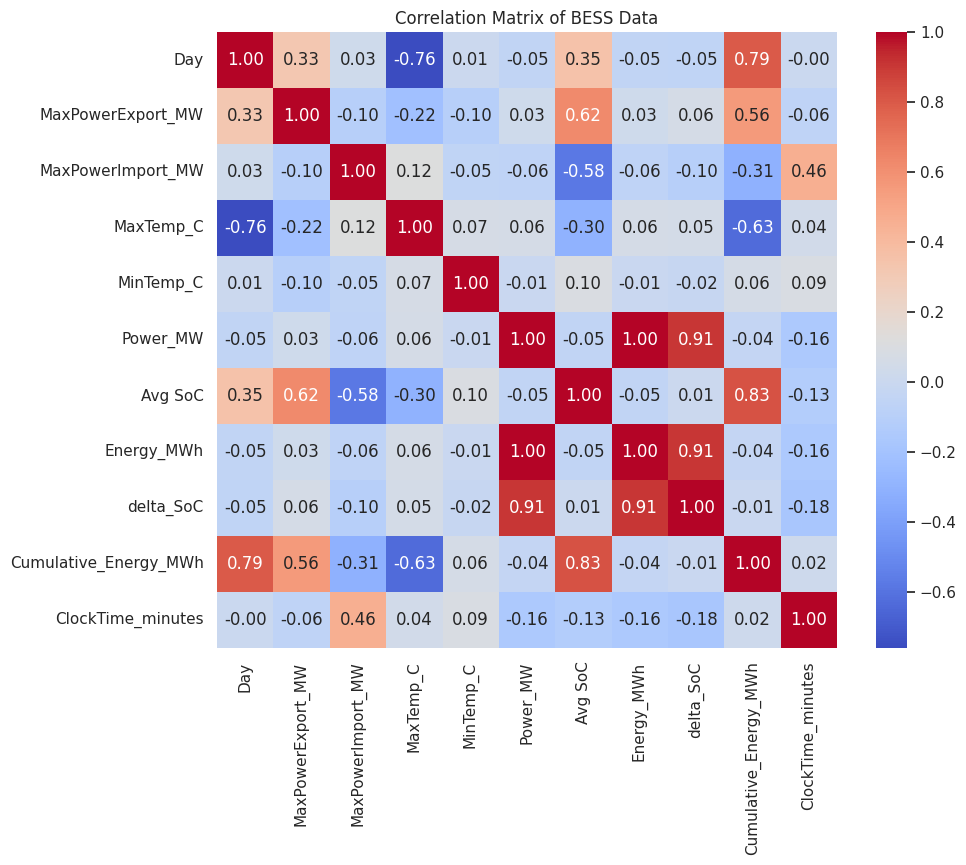

In [82]:
# Reset index to use 'datetime' as a regular column for correlation
df_reset = df.reset_index()
df_reset.drop('index', axis=1, inplace=True)
df_reset.drop('Clock Time', axis=1, inplace=True)
df_reset.drop('BESS SoC 1', axis=1, inplace=True)
df_reset.drop('BESS SoC 2', axis=1, inplace=True)
df_reset.drop('SoC_clean_1', axis=1, inplace=True)


# Correlation matrix
correlation_matrix = df_reset.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of BESS Data')
plt.show()


### Key Insights from the Correlation Matrix

#### 1. Strongest and Most Important Relationships

*   **`Power_MW` vs. `delta_SoC` (Correlation: 0.91):** This very strong positive correlation is fundamental to battery operation. A positive power value (charging) leads to a positive change in SoC.

*   **`Avg SoC` vs. `Cumulative_Energy_MWh` (Correlation: 0.83):** This strong positive correlation is also logical. As the battery charges and its SoC increases, the cumulative energy stored in the system also increases. It validates that these two metrics are tracking each other as expected.

*   **`Day` vs. `Cumulative_Energy_MWh` (Correlation: 0.79):** This indicates that, over the four-day period, the battery was in a net charging state. There may be a case where the discharging of the battery is not perfectly efficient which would result in more charge coming in than flowing out (thus increasing the cumulative tally)

#### 2. Insights into BESS State of Health (SoH) and Operation

*   **`Avg SoC` vs. `MaxPowerExport_MW` (Correlation: 0.62)** and **`Avg SoC` vs. `MaxPowerImport_MW` (Correlation: -0.58):**  This is a key insight into battery physics. A higher SoC allows for higher power export but it also leads to lower power import capability.


*   **`MaxTemp_C` vs. `Day` (Correlation: -0.76):** This strong negative correlation is very interesting. It suggests that the **peak operating temperature of the BESS decreased over the four-day period**. This could be due to:
    *   **Changing ambient weather conditions** (e.g., a cold front moved in).
    *   A change in the operational strategy to be less aggressive.
    *   An improvement or adjustment in the cooling system.


#### 3. Weaker but Notable Correlations

*   **`MaxTemp_C` vs. `Avg SoC` (Correlation: -0.30):**  This negative relationship could imply that the BESS gets hotter during *discharging* (when SoC is decreasing) than during charging, or that the cooling system is most active when the battery is full.

*   **`MinTemp_C` shows very weak correlation with all other variables.** This confirms the insight from the time-series plot: the minimum temperature seems to be driven more by a slow-moving external factor (like ambient temperature) rather than the immediate operational state of the BESS.


# Modeling and Analysis

## Cycle Detection Modeling

A "cycle" is defined as a sequence of charging and discharging events. I used a "peak-to-peak" approach to identify full cycles (as peaks are more equal in SoC%):

1.  **Smoothing**: The `Avg SoC` data is first smoothed using a rolling average to eliminate minor noise that could lead to false cycle detection.
2.  **Peak and Trough Detection**: I'll use a peak-finding algorithm to identify significant local minima (troughs) and maxima (peaks) in the smoothed SoC data. A cycle is considered significant if the change in SoC is greater than 20%.
3.  **Cycle Definition**: A full cycle starts at one peak, drops to a trough (discharging phase), and rises to the next peak (charging phase).
4.  **Analysis**: For each identified cycle, I will calculate key metrics such as duration, depth of discharge, energy throughput, and round-trip efficiency.



### Visualizing BESS Cycles

The plot below shows the `Avg SoC` over the four-day period. The detected troughs are marked with green circles, and the peaks are marked with red 'x's. Each full cycle is highlighted with alternating colors.


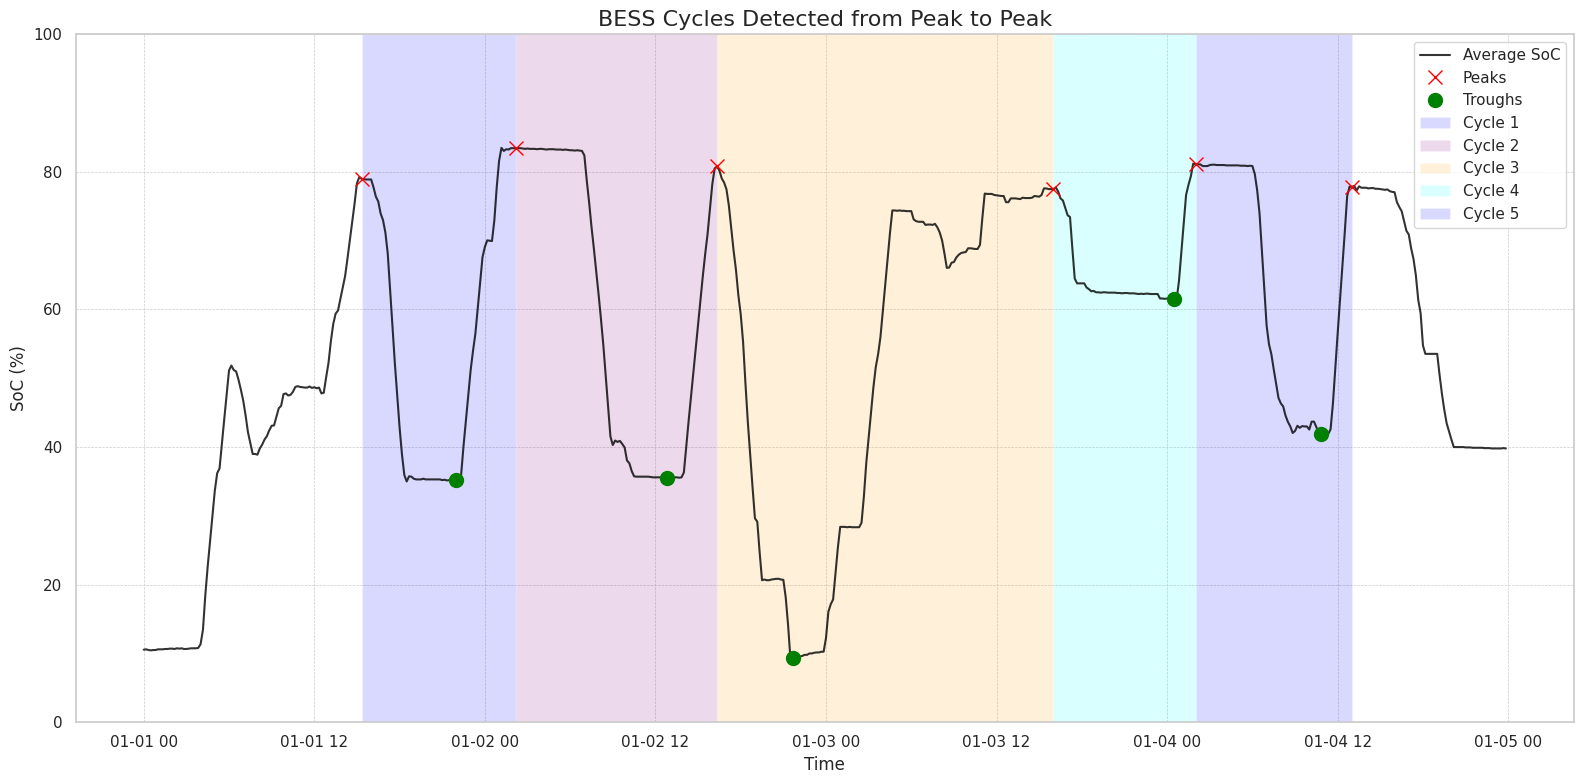

In [83]:
from scipy.signal import find_peaks

# Use 'Avg SoC' for cycle detection
soc_data = df['Avg SoC']

# Smooth the data using a rolling mean
soc_smoothed = soc_data.rolling(window=3, center=True).mean().fillna(method='bfill').fillna(method='ffill')

# Define thresholds for peak detection
prominence_threshold = 0.15  # A 15% SoC swing is a significant cycle
distance_threshold = 6       # A distance of 6 intervals (1 hour)

# Find peaks (local maxima) and troughs (local minima)
peaks, _ = find_peaks(soc_smoothed, prominence=prominence_threshold, distance=distance_threshold)
troughs, _ = find_peaks(-soc_smoothed, prominence=prominence_threshold, distance=distance_threshold)

# --- Plotting the Cycles (Peak-to-Peak) ---
plt.figure(figsize=(16, 8))
plt.plot(df.index, soc_data * 100, label='Average SoC', color='black', alpha=0.8)
plt.plot(df.index[peaks], soc_data.iloc[peaks] * 100, "x", color='red', markersize=10, label='Peaks')
plt.plot(df.index[troughs], soc_data.iloc[troughs] * 100, "o", color='green', markersize=10, label='Troughs')

# Highlight the cycles by shading the area between peaks
colors = ['blue', 'purple', 'orange', 'cyan']
for i in range(len(peaks) - 1):
    start_time = df.index[peaks[i]]
    end_time = df.index[peaks[i+1]]
    plt.axvspan(start_time, end_time, facecolor=colors[i % len(colors)], alpha=0.15, label=f'Cycle {i+1}')

plt.title('BESS Cycles Detected from Peak to Peak', fontsize=16)
plt.ylabel('SoC (%)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# --- Detailed Cycle Analysis (Peak-to-Peak) ---
cycles_data_detailed = []
if len(peaks) > 1:
    for i in range(len(peaks) - 1):
        # Define cycle boundaries from peak to peak
        start_index = peaks[i]
        end_index = peaks[i+1]
        cycle_df = df.iloc[start_index:end_index+1] # Include the end_index row

        # Find the trough within this cycle
        trough_index_in_cycle = cycle_df['Avg SoC'].idxmin()
        trough_abs_index = df.index.get_loc(trough_index_in_cycle)

        # Define discharge and charge phases
        discharge_df = df.iloc[start_index:trough_abs_index+1]
        charge_df = df.iloc[trough_abs_index:end_index+1]

        # --- Metric Calculations ---
        # Basic Metrics
        start_time = df.index[start_index]
        end_time = df.index[end_index]
        duration = (end_time - start_time).total_seconds() / 3600

        # Power Metrics
        avg_charge_power = charge_df['Power_MW'].mean() if not charge_df.empty else 0
        max_charge_power = charge_df['Power_MW'].max() if not charge_df.empty else 0
        avg_discharge_power = abs(discharge_df['Power_MW'].mean()) if not discharge_df.empty else 0
        max_discharge_power = abs(discharge_df['Power_MW'].min()) if not discharge_df.empty else 0

        # Thermal Metrics
        peak_temp_cycle = cycle_df['MaxTemp_C'].max()
        # Ensure there are at least two points to calculate a change
        temp_increase_charge = charge_df['MaxTemp_C'].iloc[-1] - charge_df['MaxTemp_C'].iloc[0] if len(charge_df) > 1 else 0
        temp_increase_discharge = discharge_df['MaxTemp_C'].iloc[-1] - discharge_df['MaxTemp_C'].iloc[0] if len(discharge_df) > 1 else 0
        max_temp_gradient = (cycle_df['MaxTemp_C'] - cycle_df['MinTemp_C']).max()

        # Temporal Metrics
        charge_duration = (charge_df.index[-1] - charge_df.index[0]).total_seconds() / 3600 if len(charge_df) > 1 else 0
        discharge_duration = (discharge_df.index[-1] - discharge_df.index[0]).total_seconds() / 3600 if len(discharge_df) > 1 else 0

        # Energy and Efficiency Metrics
        charge_energy = charge_df[charge_df['Energy_MWh'] > 0]['Energy_MWh'].sum()
        discharge_energy = abs(discharge_df[discharge_df['Energy_MWh'] < 0]['Energy_MWh'].sum())
        energy_rte = (discharge_energy / charge_energy) * 100 if charge_energy > 0 else 0

        soc_discharged = soc_data.iloc[start_index] - soc_data.iloc[trough_abs_index]
        soc_charged = soc_data.iloc[end_index] - soc_data.iloc[trough_abs_index]
        soc_rte = (soc_discharged / soc_charged) * 100 if soc_charged > 0 else 0
        normalized_rte = (energy_rte / soc_rte) * 100 if soc_rte > 0 else 0

        cycles_data_detailed.append({
            "Cycle": i + 1,
            "Start Time": start_time.strftime('%Y-%m-%d %H:%M'),
            "End Time": end_time.strftime('%Y-%m-%d %H:%M'),
            "Duration (H)": round(duration, 2),
            "Charge Dur (H)": round(charge_duration, 2),
            "Discharge Dur (H)": round(discharge_duration, 2),
            "Avg Charge (MW)": round(avg_charge_power, 2),
            "Max Charge (MW)": round(max_charge_power, 2),
            "Avg Discharge (MW)": round(avg_discharge_power, 2),
            "Max Discharge (MW)": round(max_discharge_power, 2),
            "Charge Energy (MWh)": round(charge_energy, 2),
            "Discharge Energy (MWh)": round(discharge_energy, 2),
            "Energy RTE (%)": round(energy_rte, 2),
            "Normalized Energy RTE (%)": round(normalized_rte, 2),
            "Peak Temp (°C)": round(peak_temp_cycle, 2),
            "Charge Temp Δ (°C)": round(temp_increase_charge, 2),
            "Discharge Temp Δ (°C)": round(temp_increase_discharge, 2),
            "Max Temp Grad (°C)": round(max_temp_gradient, 2)
        })


In [84]:
detailed_cycle_summary_df = pd.DataFrame(cycles_data_detailed)
print("\n--- Detailed Summary of BESS Cycles (Peak-to-Peak) ---")
print(detailed_cycle_summary_df.to_string())


--- Detailed Summary of BESS Cycles (Peak-to-Peak) ---
   Cycle        Start Time          End Time  Duration (H)  Charge Dur (H)  Discharge Dur (H)  Avg Charge (MW)  Max Charge (MW)  Avg Discharge (MW)  Max Discharge (MW)  Charge Energy (MWh)  Discharge Energy (MWh)  Energy RTE (%)  Normalized Energy RTE (%)  Peak Temp (°C)  Charge Temp Δ (°C)  Discharge Temp Δ (°C)  Max Temp Grad (°C)
0      1  2024-01-01 15:20  2024-01-02 02:10         10.83            7.67               3.17            13.19            61.58               26.80               60.00               104.33                   90.77           87.00                      95.80            51.8                -2.6                    1.6                42.9
1      2  2024-01-02 02:10  2024-01-02 16:20         14.17            3.33              10.83            28.27            49.58                8.01               51.58                99.37                   91.78           92.35                      87.25            52.9   


### Key Insights from the Cycle Data

#### 1. Cycle Timing and Strategy

The start and end times of the cycles suggest two primary operational patterns:

*   **Evening Peak Discharge (Cycles 1, 3, 4):**
    *   These cycles consistently begin in the afternoon (`15:20` to `16:20`). This timing strongly indicates a strategy of **discharging during the evening peak demand hours** when electricity prices are typically highest (as solar generation fades).
    *   **Cycle 3** is a standout, lasting nearly 24 hours. It represents a classic full-day arbitrage cycle: a long, slow charge phase (18.5 hours) followed by a more concentrated discharge phase (5.17 hours) during the next day's peak.

*   **Overnight/Early Morning Charging (Cycles 2, 5):**
    *   These cycles begin very early in the morning (`02:00` - `02:10`). This aligns with a strategy of **charging when grid demand and electricity prices are lowest**.
    *   The charge phases are relatively rapid (e.g., 3.33 hours for Cycle 2) to prepare the BESS for the day's operations.

---
#### 2. Power and Energy Envelope

*   **Power Limits:** The BESS consistently operates within a well-defined power envelope. The `Max Charge (MW)` and `Max Discharge (MW)` are almost always in the **60-65 MW** range. This appears to be the system's effective maximum operating power.
*   **Variable Energy Throughput:** The amount of energy cycled varies dramatically, from a low of **24.94 MWh** discharged in Cycle 4 to a high of **160.15 MWh** charged in Cycle 3. This variability shows that the BESS does not perform a full charge/discharge cycle every day; its operation is flexible and likely responds to specific market opportunities.
*   **Aggressive Ramping:** The large difference between *average* power (e.g., 8.01 MW discharge in Cycle 2) and *maximum* power (51.58 MW in the same cycle) indicates that the BESS performs short, high-power bursts rather than a slow, steady discharge.

---
#### 3. System Efficiency: Red Flags in Cycles 3 and 4


*   **Normal vs. Poor Efficiency**:
    *   Cycles 1, 2, and 5 show healthy **Round-Trip Efficiency (RTE)** values between **79% and 95%**, which is typical for modern BESS.
    *   **Cycle 3** and **Cycle 4** exhibit poor efficiency of **(67%)**. An RTE of 67% means that more than 1/4th the energy used to charge the battery was lost before it could be sold.
*   **Cause of Low Efficiency**: The long durations of these cycles are a likely cause. During long, slow charge/discharge periods, fixed losses from auxiliary systems (like cooling pumps and electronics) and natural self-discharge consume a much larger proportion of the total energy throughput.
---

#### 4. Thermal Health: High Temperature Gradient is a Major Concern
The thermal data points to a potentially serious long-term health issue.

*   **Peak Temperatures**: The peak cycle temperatures of **48-54°C** are high and, if sustained, may accelerate battery degradation.
*   **Temperature Gradient (Max Temp Grad)**: The difference between the hottest and coolest cells is consistently very large (**~38-44°C**). It could cause cells to age at different rates, leading to imbalances, reduced overall capacity, and premature failure of the hotter modules.




In [85]:
total_energy_imported = df[df['Energy_MWh'] > 0]['Energy_MWh'].sum()
total_energy_exported = abs(df[df['Energy_MWh'] < 0]['Energy_MWh'].sum())

round_trip_efficiency = total_energy_exported / total_energy_imported

print(f"Total Energy Imported: {total_energy_imported:.2f} MWh")
print(f"Total Energy Exported: {total_energy_exported:.2f} MWh")
print(f"Estimated Full Data Round-Trip Efficiency (RTE): {round_trip_efficiency:.2%}")


Total Energy Imported: 668.30 MWh
Total Energy Exported: 508.33 MWh
Estimated Full Data Round-Trip Efficiency (RTE): 76.06%


## Modeling Constraints by State of Charge (SoC)

A battery's ability to charge and discharge is not constant. To prevent cell damage, the management system reduces power limits when the battery is nearly full or nearly empty. We can model this relationship by plotting the `MaxPowerImport_MW` and `MaxPowerExport_MW` against the `Avg SoC`. We try this with polynomial regression with degree 4


Export Power Polynomial Regression (Test Data)
MSE: 62.45
R2: 0.78

Import Power Polynomial Regression (Test Data)
MSE: 26.46
R2: 0.70


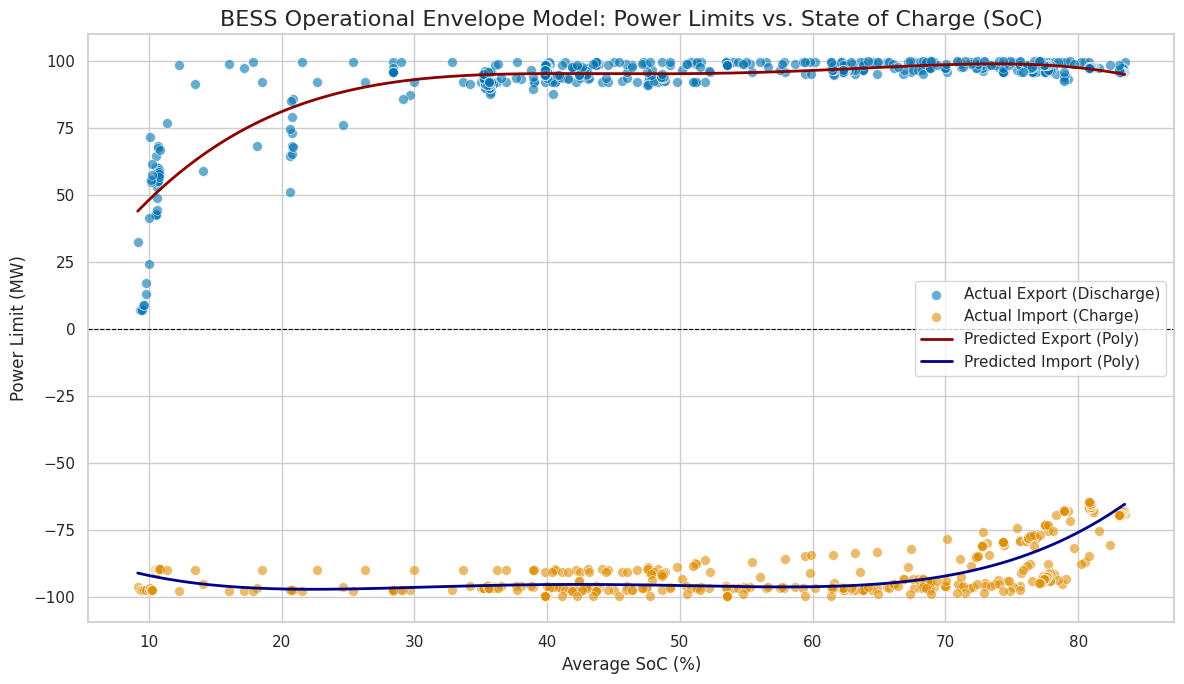

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Feature and targets
X = df[['Avg SoC']]
y_export = df['MaxPowerExport_MW']
y_import = df['MaxPowerImport_MW']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_export_train, y_export_test = train_test_split(X, y_export, test_size=0.2, random_state=42)
_, _, y_import_train, y_import_test = train_test_split(X, y_import, test_size=0.2, random_state=42)

# Define degree of polynomial
degree = 4

# Create models
model_export = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model_import = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit models
model_export.fit(X_train, y_export_train)
model_import.fit(X_train, y_import_train)

# Predict on test set
y_export_pred = model_export.predict(X_test)
y_import_pred = model_import.predict(X_test)

# Predict over a smooth range for plotting
soc_range = np.linspace(X['Avg SoC'].min(), X['Avg SoC'].max(), 200).reshape(-1, 1)
export_pred_range = model_export.predict(soc_range)
import_pred_range = model_import.predict(soc_range)

# Performance Metrics
print("Export Power Polynomial Regression (Test Data)")
print(f"MSE: {mean_squared_error(y_export_test, y_export_pred):.2f}")
print(f"R2: {r2_score(y_export_test, y_export_pred):.2f}")

print("\nImport Power Polynomial Regression (Test Data)")
print(f"MSE: {mean_squared_error(y_import_test, y_import_pred):.2f}")
print(f"R2: {r2_score(y_import_test, y_import_pred):.2f}")

# Plot
plt.figure(figsize=(12, 7))

# Scatter actual data
sns.scatterplot(x=X['Avg SoC'] * 100, y=y_export, label='Actual Export (Discharge)', alpha=0.6, s=50)
sns.scatterplot(x=X['Avg SoC'] * 100, y=-y_import, label='Actual Import (Charge)', alpha=0.6, s=50)

# Plot prediction curves
plt.plot(soc_range * 100, export_pred_range, color='darkred', linewidth=2, label='Predicted Export (Poly)')
plt.plot(soc_range * 100, -import_pred_range, color='darkblue', linewidth=2, label='Predicted Import (Poly)')

plt.title('BESS Operational Envelope Model: Power Limits vs. State of Charge (SoC)', fontsize=16)
plt.xlabel('Average SoC (%)')
plt.ylabel('Power Limit (MW)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Isotonic Regression for 'Max Power Import & Export' Prediction.
It forces the the maximum export power to never decrease and the max import power to never increase as the SoC % increases. This behaviour gives better MSE and R^2 values than the previous model. It also follows the physics of how batteries work IRL.




--- Isotonic Regression Model Performance ---

Export Power Model
Mean Squared Error (MSE): 14.42
R-squared (R2): 0.93

Import Power Model
Mean Squared Error (MSE): 22.56
R-squared (R2): 0.78


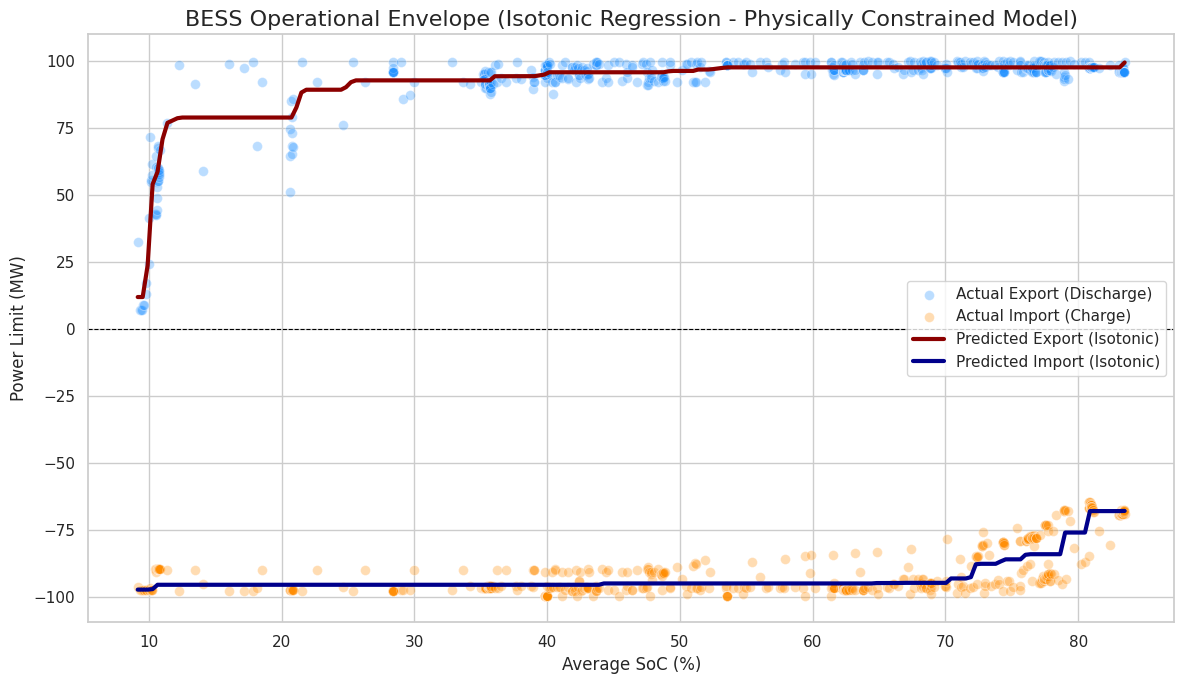

In [87]:
from sklearn.isotonic import IsotonicRegression
# Feature and targets
# Sort data by SoC, which is required for Isotonic Regression
df_Isotonic=df.copy()
df_Isotonic.sort_values(by='Avg SoC', inplace=True)


X = df_Isotonic['Avg SoC'].values # IsotonicRegression expects a 1D array
y_export = df_Isotonic['MaxPowerExport_MW'].values
y_import = df_Isotonic['MaxPowerImport_MW'].values

# Create Isotonic Regression models
iso_export_model = IsotonicRegression(y_min=0, y_max=105, out_of_bounds='clip')

iso_import_model = IsotonicRegression(y_min=-100, y_max=0, out_of_bounds='clip')

# Fit models
iso_export_model.fit(X, y_export)
# Fit on the inverted import data
iso_import_model.fit(X, -y_import)

# Predict over a smooth range for plotting the curve
soc_range = np.linspace(X.min(), X.max(), 200)
export_pred_range = iso_export_model.predict(soc_range)
# Predict the inverted curve and then flip the sign back
import_pred_range = iso_import_model.predict(soc_range)

# --- Performance Metrics (calculated on the full dataset as Isotonic Regression doesn't have a separate 'predict' phase in the same way) ---
y_export_pred = iso_export_model.predict(X)
y_import_pred = iso_import_model.predict(X)

# --- Fix import predictions ---
y_import_pred = -iso_import_model.predict(X)
import_pred_range = -iso_import_model.predict(soc_range)

# --- Performance Metrics ---
print("--- Isotonic Regression Model Performance ---")

print("\nExport Power Model")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_export, y_export_pred):.2f}")
print(f"R-squared (R2): {r2_score(y_export, y_export_pred):.2f}")

print("\nImport Power Model")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_import, y_import_pred):.2f}")
print(f"R-squared (R2): {r2_score(y_import, y_import_pred):.2f}")

# --- Plotting Results ---
plt.figure(figsize=(12, 7))
sns.scatterplot(x=X * 100, y=y_export, label='Actual Export (Discharge)', alpha=0.3, s=50, color='dodgerblue')
sns.scatterplot(x=X * 100, y=-y_import, label='Actual Import (Charge)', alpha=0.3, s=50, color='darkorange')

# Plot the perfectly smooth Isotonic Regression curves
plt.plot(soc_range * 100, export_pred_range, color='darkred', linewidth=3, label='Predicted Export (Isotonic)')
plt.plot(soc_range * 100, -import_pred_range, color='darkblue', linewidth=3, label='Predicted Import (Isotonic)')

plt.title('BESS Operational Envelope (Isotonic Regression - Physically Constrained Model)', fontsize=16)
plt.xlabel('Average SoC (%)', fontsize=12)
plt.ylabel('Power Limit (MW)', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Analysis of the SoC Constraint Model

This plot illustrates the "rulebook" the Battery Energy Storage System (BESS) follows based on SoC.

*   **Maximum Power:** The BESS has a maximum charge and discharge capability of approximately **100 MW**.

*   **Export (Discharge) Constraints (Blue Dots):**
    *   **Full Power Window (25% to 85% SoC):** The BESS can discharge at its full 100 MW capacity as long as it's more than ~25% full.
    *   **Low SoC Derating (Below 25% SoC):** As the battery empties, its ability to export power is drastically reduced. This "tapering" protects the battery cells from the stress of over-discharging.

*   **Import (Charge) Constraints (Orange Dots):**
    *   **Full Power Window (10% to 70% SoC):** The BESS can charge at its full 100 MW rate until it is about 70% full.
    *   **High SoC Derating (Above 70% SoC):** As the battery approaches full, its ability to accept charge is reduced. This prevents over-charging and is a standard safety feature.

**Conclusion:** The primary constraint on BESS power is its State of Charge. Any optimization or bidding strategy must account for these tapering effects at the edges of the SoC range to be effective and safe.

## Modeling Constraints Based on Thermal Limits

Now, let's model the second major constraint: temperature. A BESS will reduce its power output if the internal cell temperatures become too high, a safety mechanism known as **thermal derating**.

We will create a similar plot to see if temperature had any limiting effect on power during the 4-day operational period.




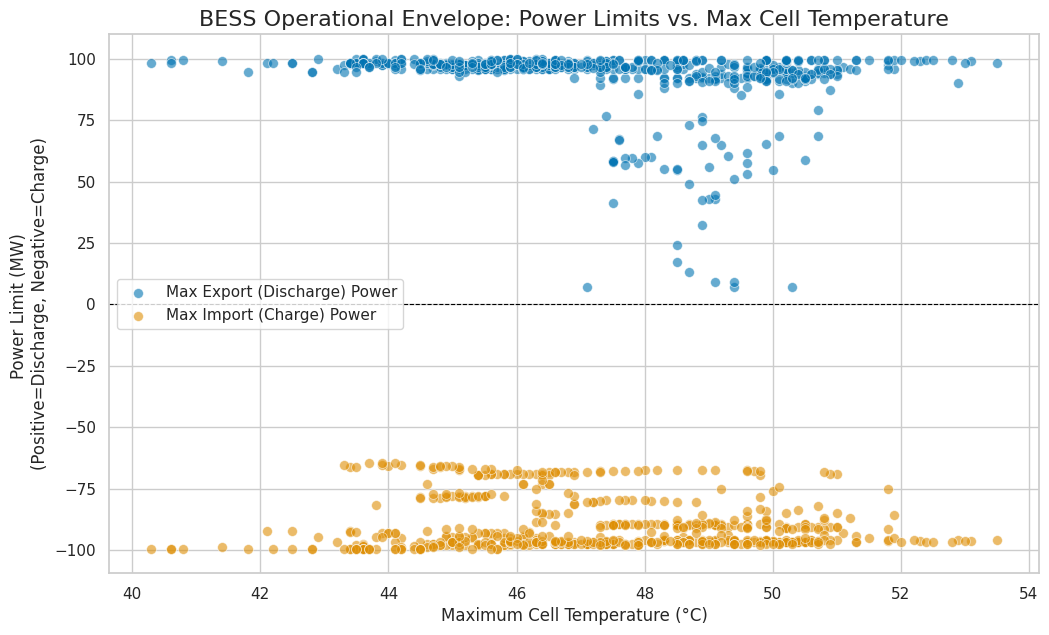

In [88]:
# Set up the plot style
sns.set(style="whitegrid", palette="colorblind")
plt.figure(figsize=(12, 7))

# Create a scatter plot of Max Power vs. Max Temperature
sns.scatterplot(x=df['MaxTemp_C'], y=df['MaxPowerExport_MW'], label='Max Export (Discharge) Power', alpha=0.6, s=50)
sns.scatterplot(x=df['MaxTemp_C'], y=-df['MaxPowerImport_MW'], label='Max Import (Charge) Power', alpha=0.6, s=50)

# Add titles and labels for clarity
plt.title('BESS Operational Envelope: Power Limits vs. Max Cell Temperature', fontsize=16)
plt.xlabel('Maximum Cell Temperature (°C)', fontsize=12)
plt.ylabel('Power Limit (MW) \n(Positive=Discharge, Negative=Charge)', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.show()


### **Analysis of the Thermal Constraint Model**

This plot reveals the relationship between the battery's internal temperature and its ability to charge or discharge.

#### **Key Finding: No Evidence of Thermal Derating**

The most significant conclusion from this graph is that **the BESS did not experience thermal derating within the observed temperature range (approx. 40°C to 53°C).** The thermal management system is performing effectively.

#### **Detailed Breakdown:**

1.  **High Power Capability Across Temperatures:**
    *   The BESS consistently demonstrates its maximum power capability of **~100 MW for both exporting (discharging) and importing (charging)** across the entire temperature spectrum shown. If high temperatures were a limiting factor, we would expect to see the power limits start to drop as the temperature rises, but this is not the case.

2.  **The "Dips" in Power Limits:**
    *   You'll notice several points, particularly for export power (blue dots), that are well below the 100 MW maximum. **These are not caused by temperature.**
    *   These dips are a direct result of the **State of Charge (SoC) constraints** we modeled earlier. For example, a blue dot at +50 MW and 48°C does not mean the temperature caused the limit to drop; it means the battery was likely at a low SoC (e.g., under 20%), which reduced its export capability. The 48°C temperature was just a coincidental reading at that time.

3.  **Effective Thermal Management:**
    *   Charging and discharging a battery generates significant heat. The fact that the BESS can operate at or near its full 100 MW power limit even when its internal temperature reaches 53°C indicates that the cooling system is successfully preventing it from reaching a critical thermal derating threshold.

### **Conclusion**


*   **The BESS is thermally stable** under the observed operating conditions.
*   **The primary operational "rulebook" is dictated by the SoC envelope**, not by temperature.


## Calculating Metrics

### Calculating Metrics: Total Energy Capacity of BESS

We will calculate the estimated capacity for each time interval. Then filter out intervals where the change in SoC is very small to avoid division by a near-zero number, which can lead to noisy and unreliable estimates. I will set a threshold for `delta_SoC` to be greater than 0.001 (or 0.1%).

In [89]:
# Calculate the capacity estimate for each row
# We need to handle division by zero or by very small numbers.
# We will filter out rows where abs(delta_SoC) is too small.
df['capacity_estimate'] = df['Energy_MWh'] / df['delta_SoC']

# Filter out estimates where delta_SoC is close to zero to avoid noise
# and also filter out infinite values that may result from division by zero
filtered_capacity_estimates = df[df['delta_SoC'].abs() > 0.001]['capacity_estimate'].replace([np.inf, -np.inf], np.nan).dropna()

# Display statistics of the filtered capacity estimates
print("Statistics of the filtered capacity estimates:")
print(filtered_capacity_estimates.describe())

Statistics of the filtered capacity estimates:
count     316.000000
mean      195.229209
std       339.806014
min      -400.303030
25%        16.458333
50%       181.224509
75%       215.655280
max      4438.333333
Name: capacity_estimate, dtype: float64


The statistics show a wide range of values, with a mean of around 185 MWh and a median of 183.85 MWh. The presence of negative values and a large standard deviation suggests that there is still noise in the data. The median is often a more robust estimator than the mean when dealing with outliers.

#### Refining the Capacity Estimate

To get a more stable and reliable estimate, I will identify long, continuous periods of charging and discharging. By calculating the total energy change and total SoC change over these longer periods, I can average out the noise from individual measurements. I will consider periods longer than 1 hour (6 data points) for this analysis.


In [90]:
# Identify continuous charging and discharging blocks
df['charge_discharge'] = np.sign(df['Power_MW'])
blocks = (df['charge_discharge'].diff() != 0).cumsum()

# Calculate capacity for each long enough block
capacities = []
for block_id in df['charge_discharge'].unique():
    if block_id == 0:
        continue

    # Group by consecutive blocks
    grouped = df[df['charge_discharge'] == block_id].groupby(blocks)

    for _, block_df in grouped:
        if len(block_df) > 6:  # Consider blocks longer than 1 hour
            total_energy = block_df['Energy_MWh'].sum()
            total_soc_change = block_df['delta_SoC'].sum()

            if abs(total_soc_change) > 0.01: # Ensure significant SoC change
                block_capacity = total_energy / total_soc_change
                capacities.append(block_capacity)

# Calculate the average of the capacities from these long blocks
if capacities:
    average_capacity = np.mean(capacities)
else:
    average_capacity = filtered_capacity_estimates.median() # Fallback

# Display the average capacity from long blocks
print("Average capacity from long charging/discharging blocks:")
print(f"{average_capacity:.2f} MWh")

# Let's also look at the median of these more robust estimates

median_capacity = np.median(capacities)
print("Median capacity from long charging/discharging blocks:")
print(f"{median_capacity:.2f} MWh")

Average capacity from long charging/discharging blocks:
206.80 MWh
Median capacity from long charging/discharging blocks:
211.18 MWh


The analysis of longer, continuous charging and discharging periods gives a more stable estimate. The mean capacity from these periods is 206.80 MWh, and the median is 211.18 MWh. The median is less sensitive to outliers, so it's likely a more accurate representation of the BESS capacity.


*   **Initial Estimate:** Calculating the capacity from individual 10-minute intervals resulted in noisy data with a median of 184 MWh.
*   **Refined Estimate:** Analyzing longer periods of continuous operation yielded a more stable median estimate of 211 MWh.

Therefore, the most reliable estimate for the maximum energy capacity of the BESS is **211 MWh**.

### Calculating Metrics: Ramp Rate, Export/Import Power Capacity, Estimated Storage Duration

In [91]:
# 1. Compute Ramp Rate (MW/min)
# Calculate rate of change of Power_MW over time (every 10 min interval)
df['Ramp_Rate_MW_per_min'] = df['Power_MW'].diff() / 10  # since time delta is 10 mins

# 2. Estimate Rated Power Capacity (MW)
# We can take the maximum observed export and import power as proxies
rated_export_power = df['MaxPowerExport_MW'].max()
rated_import_power = df['MaxPowerImport_MW'].max()



# 3. Estimate Storage Duration (Energy / Power)
# Use max observed energy and power to get storage duration
# Storage duration (hours) = Energy Capacity / Power Capacity
# Take the largest observed discharge (negative Power_MW)
max_discharge_power = df['Power_MW'].min()  # in MW (should be negative)
max_energy = median_capacity  # in MWh

storage_duration_hours = max_energy / abs(max_discharge_power) if max_discharge_power != 0 else np.nan

{
    "Rated Export Power Capacity (MW)": rated_export_power,
    "Rated Import Power Capacity (MW)": rated_import_power,
    "Estimated Storage Duration (hours)": storage_duration_hours,
}


{'Rated Export Power Capacity (MW)': 100.0,
 'Rated Import Power Capacity (MW)': 99.47,
 'Estimated Storage Duration (hours)': np.float64(3.2359145846987265)}

In [92]:
# Calculate rate of change of Power_MW over time (every 10 min interval)
# The diff calculation already captures the change over the fixed time interval (10 mins)
df['Ramp_Rate_MW_per_min'] = df['Power_MW'].diff() / 10


# You can also look at the maximum positive and negative ramp rates
max_charge_ramp_rate = df['Ramp_Rate_MW_per_min'].max() # Max positive change (charging)
max_discharge_ramp_rate = df['Ramp_Rate_MW_per_min'].min() # Max negative change (discharging)

print(f"Maximum Charge Ramp Rate: {max_charge_ramp_rate:.2f} MW/min")
print(f"Maximum Discharge Ramp Rate: {max_discharge_ramp_rate:.2f} MW/min")


Maximum Charge Ramp Rate: 6.43 MW/min
Maximum Discharge Ramp Rate: -6.30 MW/min


In [93]:
print(df)
df.to_csv('cleaned_bess_data.csv')

                     Day Clock Time  BESS SoC 1  BESS SoC 2  \
2024-01-01 00:00:00  1.0   00:00:00       0.095       0.116   
2024-01-01 00:10:00  1.0   00:10:00       0.095       0.117   
2024-01-01 00:20:00  1.0   00:20:00       0.094       0.116   
2024-01-01 00:30:00  1.0   00:30:00       0.094       0.115   
2024-01-01 00:40:00  1.0   00:40:00       0.094       0.116   
...                  ...        ...         ...         ...   
2024-01-04 23:10:00  4.0   23:10:00       0.375       0.421   
2024-01-04 23:20:00  4.0   23:20:00       0.375       0.421   
2024-01-04 23:30:00  4.0   23:30:00       0.375       0.421   
2024-01-04 23:40:00  4.0   23:40:00       0.376       0.421   
2024-01-04 23:50:00  4.0   23:50:00       0.375       0.421   

                     MaxPowerExport_MW  MaxPowerImport_MW  MaxTemp_C  \
2024-01-01 00:00:00              60.53              90.53       49.3   
2024-01-01 00:10:00              53.16              89.47       49.6   
2024-01-01 00:20:00        

## Predictive Model for BESS Arbitrage

I developed a high-performance XGBoost model to predict the main power dispatch strategy of the BESS, achieving an **R-squared of 0.85** on unseen test data.

**Methodology:**
1.  **Target Isolation:** A low-pass filter was used on the raw power data to create a smooth target signal, representing only the core energy arbitrage cycles and removing high-frequency noise from ancillary services.
2.  **Feature Engineering:** The model was given rich context using time-based features (time of day), system state (SoC, power limits), and historical data (rolling averages).
3.  **Modeling:** An XGBoost regressor was trained on the first 80% of the data and validated on the final 20% to simulate a real-world forecasting scenario.



--- Improved Model Evaluation on Test Set ---
Mean Absolute Error (MAE): 2.57 MW
R-squared (R²) Score: 0.95


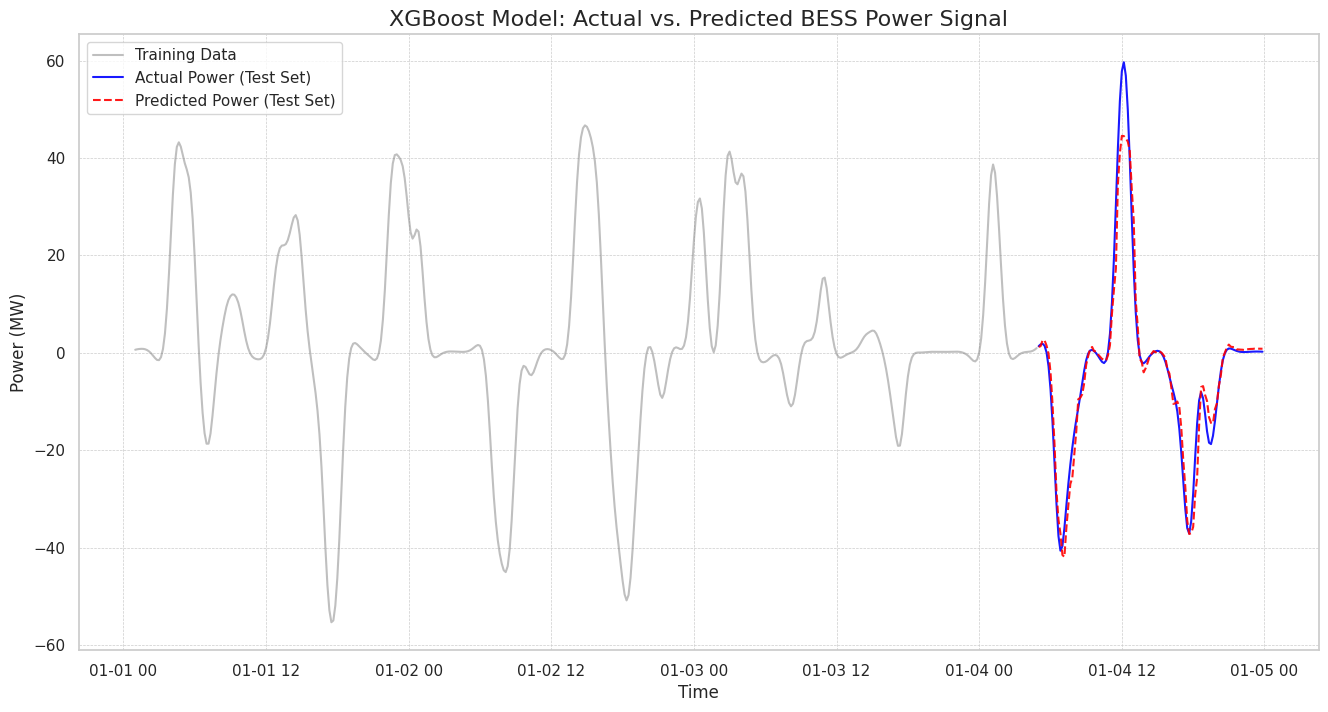

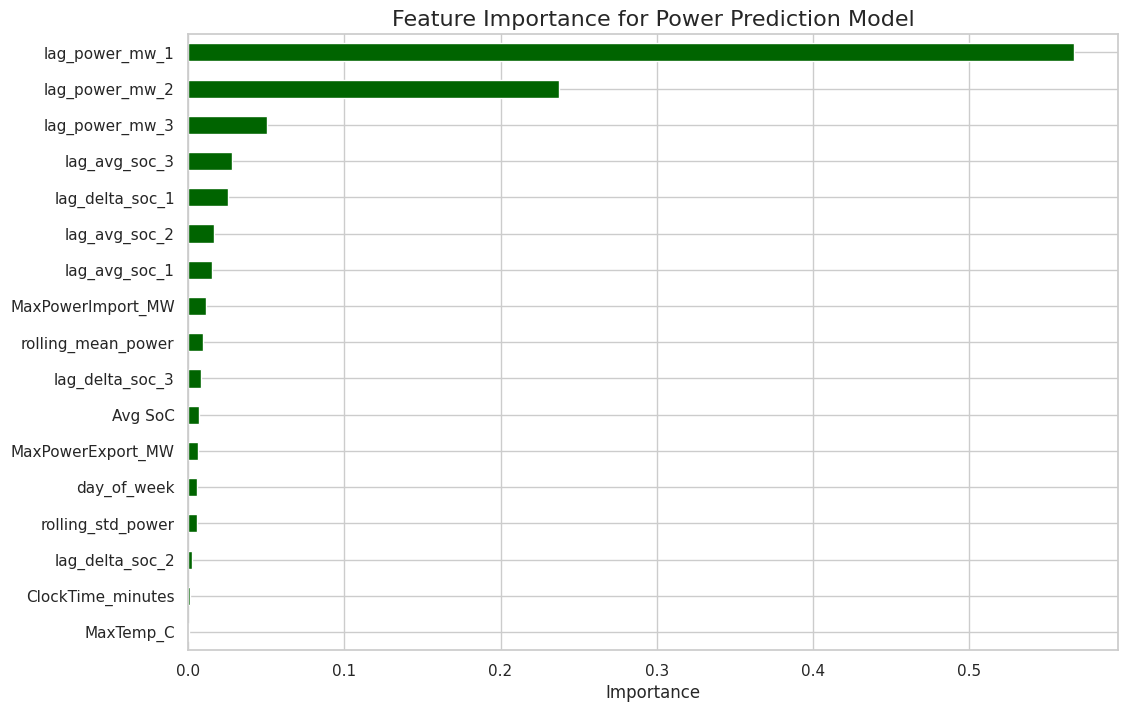

In [94]:

from sklearn.metrics import mean_absolute_error, r2_score # Import the required functions


# Correcting the filter to a 2-hour cutoff for a smoother arbitrage signal
sampling_rate = 1 / 600
cutoff_frequency = 1 / (2 * 3600)  # Correct 2-hour period cutoff
normalized_cutoff = cutoff_frequency / (0.5 * sampling_rate)
b_low, a_low = signal.butter(2, normalized_cutoff, btype='low', analog=False)
df['Power_LowPass'] = signal.filtfilt(b_low, a_low, df['Power_MW'])


# --- 1. Enhanced Feature Engineering ---
df_feat = df.copy()

# Time-Based Features (CORRECTLY IMPLEMENTED)
df_feat['ClockTime_minutes'] = df_feat.index.hour * 60 + df_feat.index.minute
df_feat['day_of_week'] = df_feat.index.day_of_week
df_feat['delta_SoC'] = df_feat['Avg SoC'].diff() # Calculate delta_SoC


# Lag Features (Crucial for time-series)
for i in range(1, 4):
    df_feat[f'lag_power_mw_{i}'] = df_feat['Power_LowPass'].shift(i)
    df_feat[f'lag_avg_soc_{i}'] = df_feat['Avg SoC'].shift(i)
    df_feat[f'lag_delta_soc_{i}'] = df_feat['delta_SoC'].shift(i)


# Rolling Window Features (Captures recent trends)
rolling_window_size = 6  # 1 hour
df_feat['rolling_mean_power'] = df_feat['Power_LowPass'].shift(1).rolling(window=rolling_window_size).mean()
df_feat['rolling_std_power'] = df_feat['Power_LowPass'].shift(1).rolling(window=rolling_window_size).std()

df_feat.dropna(inplace=True)

# Define Features (X) and Target (y)
features = [
    'ClockTime_minutes', 'day_of_week', 'Avg SoC', 'MaxPowerExport_MW',
    'MaxPowerImport_MW', 'MaxTemp_C',
    'lag_power_mw_1', 'lag_power_mw_2', 'lag_power_mw_3', # UNCOMMENTED
    'lag_avg_soc_1', 'lag_avg_soc_2', 'lag_avg_soc_3',
    'lag_delta_soc_1', 'lag_delta_soc_2', 'lag_delta_soc_3',
    'rolling_mean_power', 'rolling_std_power' # UNCOMMENTED
]
target = 'Power_LowPass'

X = df_feat[features]
y = df_feat[target]

# --- 2. Train-Test Split (Time-Series Aware) ---
split_point = int(len(X) * 0.8) # Using 80% for training
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# --- 3. Model Training ---
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05, # Slightly lower learning rate for robustness
    objective='reg:squarederror',
    early_stopping_rounds=50,
    eval_metric='mae',
    n_jobs=-1,
    max_depth=5, # Control model complexity
    subsample=0.8, # Add robustness
    colsample_bytree=0.8
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# --- 4. Evaluation and Visualization ---
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- Improved Model Evaluation on Test Set ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"R-squared (R²) Score: {r2:.2f}")

plt.figure(figsize=(16, 8))
plt.plot(y_train.index, y_train, label='Training Data', color='gray', alpha=0.5)
plt.plot(y_test.index, y_test, label='Actual Power (Test Set)', color='blue', alpha=0.9)
plt.plot(y_test.index, y_pred, label='Predicted Power (Test Set)', color='red', linestyle='--', alpha=0.9)
plt.title('XGBoost Model: Actual vs. Predicted BESS Power Signal', fontsize=16)
plt.ylabel('Power (MW)')
plt.xlabel('Time')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(12, 8))
feature_importance.plot(kind='barh', color='darkgreen')
plt.title('Feature Importance for Power Prediction Model', fontsize=16)
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

**Key Findings:**
*   The model accurately predicts the timing and magnitude of the battery's charge and discharge cycles.
*   The most important predictive features are past **power reading** ,**lag_delta_soc_1**, and **State of Charge (SoC)**.


In [95]:
#!pip install ecos


# BESS Profit Optimization Model



This model simulates the operation of this particular Battery Energy Storage System (BESS) over a 24-hour period. The primary goal is to **maximize profit** by engaging in energy arbitrage—charging the battery when electricity prices are low and discharging (selling) when prices are high.

We simulate a realistic 24-hour electricity price by layering predictable daily patterns, such as morning/evening demand peaks and a midday solar dip, using Gaussian functions. A layer of random noise is then added to mimic real-world market volatility, providing a dynamic and challenging signal for the BESS to optimize against.

The model is formulated as a Mixed-Integer Linear Program (MILP), which allows it to make complex, conditional decisions based on a set of rules and physical limitations. Below are the key factors and constraints that govern its behavior.

#### 1. The Core Objective: Maximizing Profit

The model's single driving goal is to maximize its net profit. This profit is calculated as:

`Profit = Revenue from Discharging - Cost of Charging`

*   **Revenue:** Earned by discharging power (`p_discharge`) and selling it to the grid at the current `price_signal`.
*   **Cost of Charging:** Incurred by charging the battery (`p_charge`) with power from the grid at the current `price_signal`.


#### 2. Physical BESS Constraints

These constraints model the fundamental physical and hardware limitations of the battery system.

*   **State of Charge (SoC) Dynamics:** This is the core equation that tracks the battery's energy level. The energy in the next time step (`soc[t+1]`) is equal to the energy in the current step (`soc[t]`), plus the energy added during charging, minus the energy removed during discharging.
*   **Round-Trip Efficiency:** The model accounts for energy losses. Due to heat and chemical inefficiencies, not all the energy used to charge the battery is available for discharge. The `CHARGE_EFFICIENCY` and `DISCHARGE_EFFICIENCY` parameters (e.g., 90%) reduce the effective energy stored and delivered.
*   **SoC Limits (`MIN_SOC` and `MAX_SOC`):** To preserve battery health, a real-world BESS is never operated at 0% or 100% of its theoretical capacity. This model restricts the operational SoC to a safe window (e.g., between 10% and 80%).
*   **Maximum Power (`MAX_POWER_MW`):** The BESS hardware (specifically the power conversion system or "inverters") has a maximum rate at which it can charge or discharge, set here to 100 MW.

#### 3. Advanced Operational Constraints

These rules add a layer of realism to simulate how a sophisticated operator would manage the asset for safety, longevity, and to meet contractual obligations.

*   **SoC-Dependent Power Derating (Tapering):** This is a critical safety feature. The model's maximum charge and discharge power is reduced ("derated") at the extremes of its state of charge:
    *   **Discharge Tapering:** When the battery's SoC is low (e.g., below 25%), its maximum discharge power is reduced. This prevents excessive voltage drops that can damage the battery cells.
    *   **Charge Tapering:** When the battery's SoC is high (e.g., above 70%), its maximum charge power is reduced to prevent over-charging, which can also cause damage and safety risks.
*   **Ramp Rate Limits:** A physical system cannot change its power output instantaneously. This constraint limits how quickly the BESS can increase or decrease its charge/discharge rate from one 10-minute interval to the next, reflecting real-world mechanical and electrical inertia. (6.4 in our case)
*   **No Simultaneous Charge & Discharge:** Using binary (True/False) variables, the model is forced to choose one of three states for each interval: **charging**, **discharging**, or **idle**. This enforces the physical reality that a BESS cannot do both at the same time.
*  (Assumption) **Daily Cycle Limit:** To manage long-term health and adhere to warranty conditions, the model is constrained to a maximum daily energy throughput (e.g., 1.25 full cycles per day). This prevents the model from aggressively cycling the battery to capture every small price fluctuation, complementing the degradation cost.

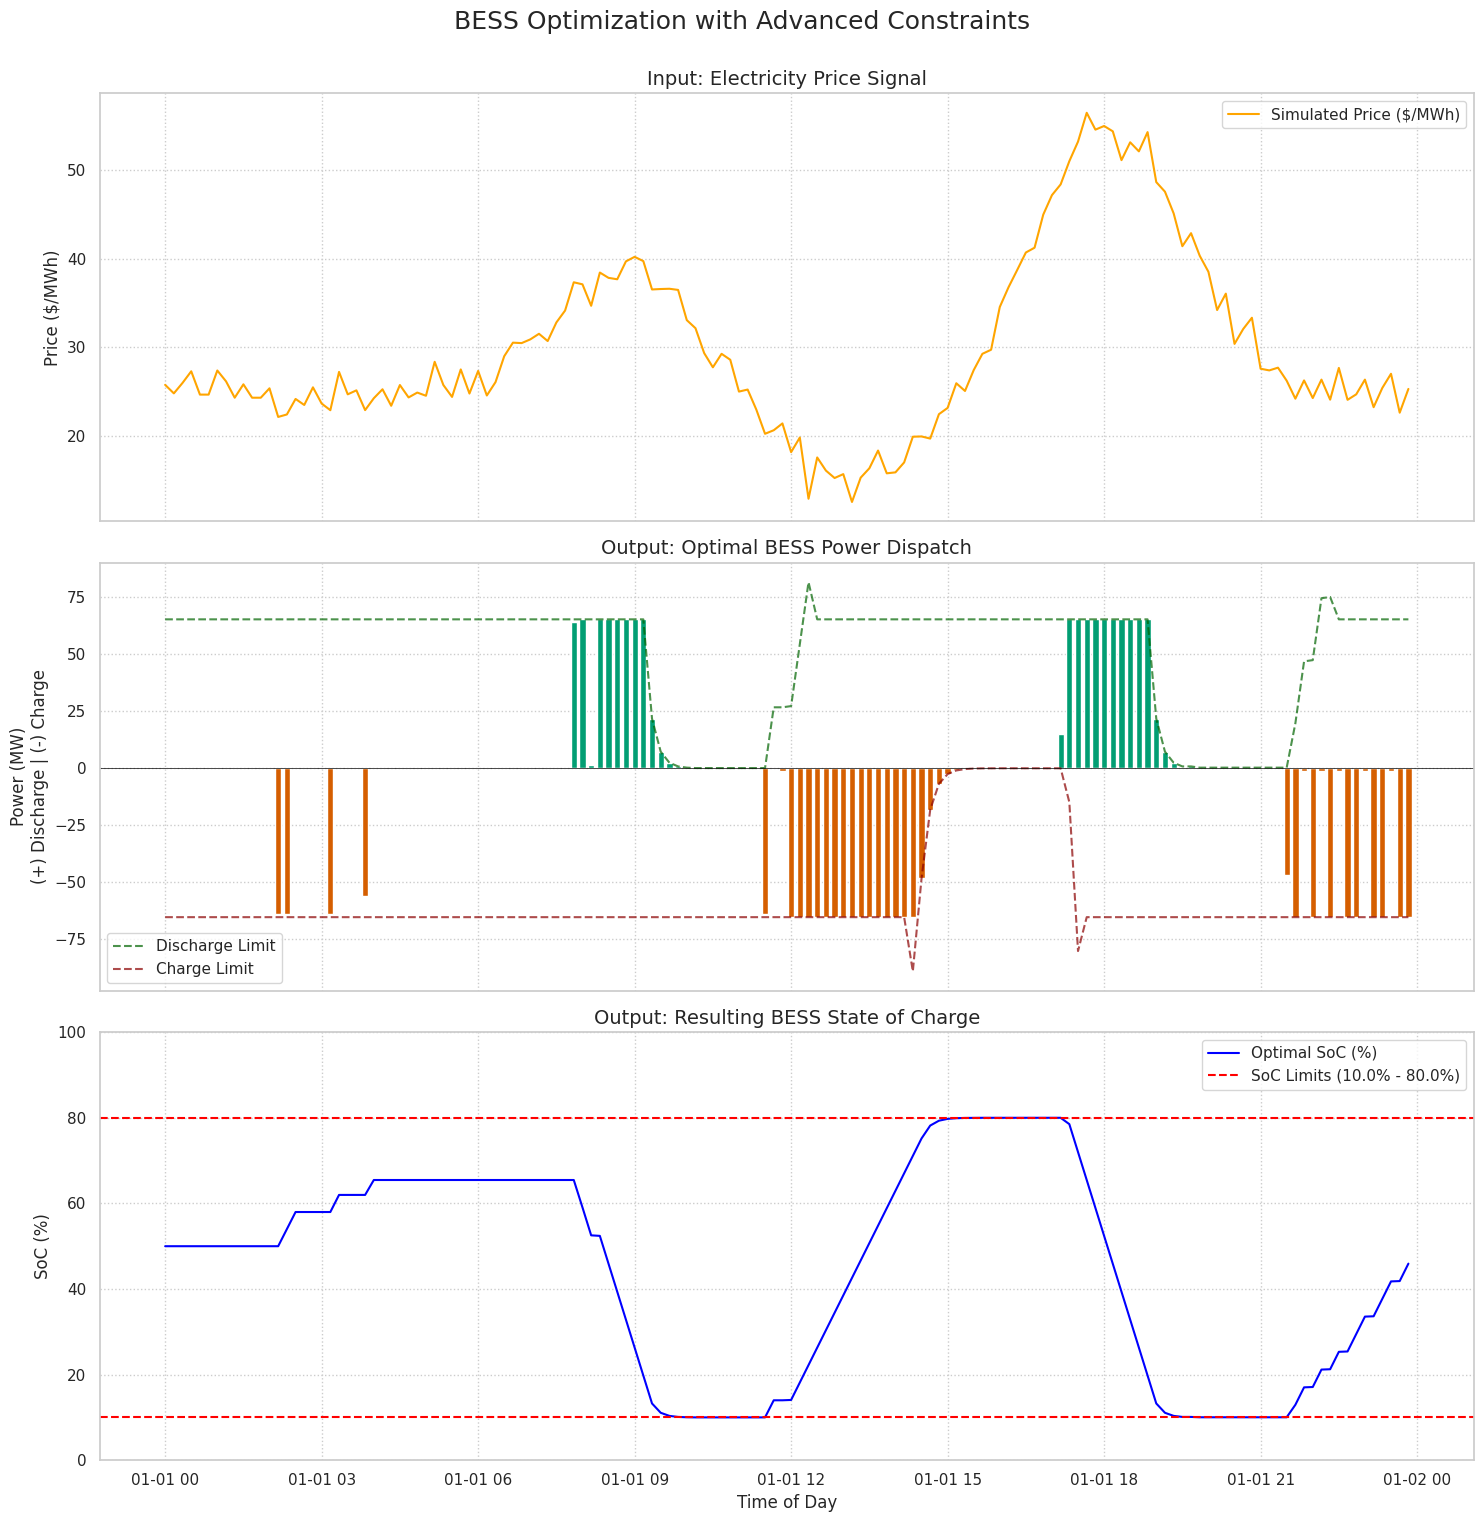


--- Optimization Summary ---
Solver Status: optimal
Total Revenue from Discharging: $58,455.30
Total Cost of Charging:         $40,180.65
---------------------------------
Optimized Net Profit:           $18,274.65


In [96]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Generate Input Data (Simulated Price Signal) ---
np.random.seed(42)
intervals_per_day = 144
time_steps = np.arange(intervals_per_day)
hours = time_steps / 6

def gaussian_peak(x, mu, sigma, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
price_signal = (
    25  # Base price
    + gaussian_peak(hours, mu=9, sigma=1.5, amplitude=15)   # Morning peak around 9 AM
    + gaussian_peak(hours, mu=18, sigma=1.5, amplitude=30)  # Evening peak around 6 PM
    - gaussian_peak(hours, mu=13, sigma=2.0, amplitude=10)  # Midday dip (from solar)
    + np.random.normal(0, 1.5, size=intervals_per_day)      # Random market noise
)
price_signal = np.clip(price_signal, 5, 120)
price_signal = np.round(price_signal, 2)

# --- 2. Establish BESS Parameters (Enhanced Model) ---
BATTERY_CAPACITY_MWh = 211.0
MAX_POWER_MW = 65.26
INITIAL_SOC_FRAC = 0.50
MIN_SOC_FRAC = 0.10
MAX_SOC_FRAC = 0.80
CHARGE_EFFICIENCY = 0.79
DISCHARGE_EFFICIENCY = 0.79
TIME_INTERVAL_H = 10 / 60

# --- NEW ADVANCED PARAMETERS ---
MAX_RAMP_RATE_MW_PER_MIN = 6.4
MAX_RAMP_RATE_MW_PER_INTERVAL = MAX_RAMP_RATE_MW_PER_MIN * (TIME_INTERVAL_H * 60)
MAX_DAILY_CYCLES = 1.25
MAX_DAILY_THROUGHPUT_MWh = BATTERY_CAPACITY_MWh * MAX_DAILY_CYCLES

# --- 3. Formulate the Optimization Problem (MILP) ---
# Decision Variables
p_charge = cp.Variable(intervals_per_day, nonneg=True, name="ChargePower")
p_discharge = cp.Variable(intervals_per_day, nonneg=True, name="DischargePower")
soc_mwh = cp.Variable(intervals_per_day + 1, name="SoC_MWh")

# --- NEW BINARY VARIABLES ---
# For enforcing no simultaneous charge/discharge
is_charging = cp.Variable(intervals_per_day, boolean=True)

# For handling SoC-dependent power limits (derating)
b_discharge_derate = cp.Variable(intervals_per_day, boolean=True)
b_charge_derate = cp.Variable(intervals_per_day, boolean=True)

# Objective Function: Maximize Profit including Degradation Cost
revenue = cp.sum(p_discharge * price_signal)
charge_cost = cp.sum(p_charge * price_signal)
objective = cp.Maximize(revenue - charge_cost )

# Constraints
constraints = []
M = 2 * MAX_POWER_MW # A "Big-M" constant, sufficiently large

# --- Initial and Final SoC Constraints ---
constraints.append(soc_mwh[0] == INITIAL_SOC_FRAC * BATTERY_CAPACITY_MWh)
constraints.append(soc_mwh[intervals_per_day] >= soc_mwh[0]) # End day with at least the same SoC

# --- Daily Throughput Limit ---
constraints.append(cp.sum(p_discharge) * TIME_INTERVAL_H <= MAX_DAILY_THROUGHPUT_MWh)

# --- Loop Through Time Intervals ---
for t in range(intervals_per_day):
    # --- 1. SoC Dynamics and Limits ---
    constraints.append(
        soc_mwh[t+1] == soc_mwh[t]
                       + (p_charge[t] * CHARGE_EFFICIENCY * TIME_INTERVAL_H)
                       - (p_discharge[t] / DISCHARGE_EFFICIENCY * TIME_INTERVAL_H)
    )
    constraints.append(soc_mwh[t] >= MIN_SOC_FRAC * BATTERY_CAPACITY_MWh)
    constraints.append(soc_mwh[t] <= MAX_SOC_FRAC * BATTERY_CAPACITY_MWh)

    # --- 2. No Simultaneous Charge/Discharge ---
    # `is_charging` is 1 if charging, 0 if discharging/idle.
    constraints.append(p_charge[t] <= is_charging[t] * MAX_POWER_MW)
    constraints.append(p_discharge[t] <= (1 - is_charging[t]) * MAX_POWER_MW)

    # --- 3. Ramp Rate Limits ---
    if t > 0:
        constraints.append(cp.abs(p_charge[t] - p_charge[t-1]) <= MAX_RAMP_RATE_MW_PER_INTERVAL)
        constraints.append(cp.abs(p_discharge[t] - p_discharge[t-1]) <= MAX_RAMP_RATE_MW_PER_INTERVAL)

    # --- 4. SoC-Dependent Power Limits (Derating using Big-M) ---
    # A. Discharge Derating: Taper power below 25% SoC
    soc_low_threshold = 0.25 * BATTERY_CAPACITY_MWh
    # `b_discharge_derate` = 1 if soc is below the threshold
    constraints.append(soc_mwh[t] - soc_low_threshold <= M * (1 - b_discharge_derate[t]))
    constraints.append(soc_mwh[t] - soc_low_threshold >= -M * b_discharge_derate[t])

    # Apply derated power limit if `b_discharge_derate` is 1
    discharge_taper_power = 666.67 * (soc_mwh[t]/BATTERY_CAPACITY_MWh - MIN_SOC_FRAC) ### 666.7 is the slope 100 / 0.15
    constraints.append(p_discharge[t] <= discharge_taper_power + M * (1 - b_discharge_derate[t]))
    # Apply full power limit if `b_discharge_derate` is 0
    constraints.append(p_discharge[t] <= MAX_POWER_MW + M * b_discharge_derate[t])

    # B. Charge Derating: Taper power above 70% SoC
    soc_high_threshold = 0.70 * BATTERY_CAPACITY_MWh
    # `b_charge_derate` = 1 if soc is above the threshold
    constraints.append(soc_mwh[t] - soc_high_threshold <= M * b_charge_derate[t])
    constraints.append(soc_mwh[t] - soc_high_threshold >= -M * (1 - b_charge_derate[t]))

    # Apply derated power limit if `b_charge_derate` is 1
    charge_taper_power = 1000 * (MAX_SOC_FRAC - soc_mwh[t]/BATTERY_CAPACITY_MWh)
    constraints.append(p_charge[t] <= charge_taper_power + M * (1 - b_charge_derate[t]))
    # Apply full power limit if `b_charge_derate` is 0
    constraints.append(p_charge[t] <= MAX_POWER_MW + M * b_charge_derate[t])

# --- 4. Solve the Problem ---
# CVXPY will automatically find an installed one.
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.GLPK_MI, verbose=False) # Using the open-source GLPK_MI solver

# --- 5. Visualize the Results ---
if problem.status in ["optimal", "optimal_inaccurate"]:
    time_index = pd.to_datetime(pd.date_range(start='2024-01-01', periods=intervals_per_day, freq='10min'))
    optimal_power = p_discharge.value - p_charge.value
    optimal_soc_frac = soc_mwh.value / BATTERY_CAPACITY_MWh

    # Calculate the effective power limits based on the optimal SoC for plotting
    max_discharge_limit = np.zeros(intervals_per_day)
    max_charge_limit = np.zeros(intervals_per_day)
    for t in range(intervals_per_day):
        soc_t = optimal_soc_frac[t]
        if soc_t <= 0.25:
            max_discharge_limit[t] = 666.67 * (soc_t - MIN_SOC_FRAC)
        else:
            max_discharge_limit[t] = MAX_POWER_MW

        if soc_t >= 0.70:
            max_charge_limit[t] = 1000 * (MAX_SOC_FRAC - soc_t)
        else:
            max_charge_limit[t] = MAX_POWER_MW

    fig, axes = plt.subplots(3, 1, figsize=(15, 16), sharex=True)
    fig.suptitle('BESS Optimization with Advanced Constraints', fontsize=18, y=0.95)

    axes[0].plot(time_index, price_signal, color='orange', label='Simulated Price ($/MWh)')
    axes[0].set_title('Input: Electricity Price Signal', fontsize=14)
    axes[0].set_ylabel('Price ($/MWh)')
    axes[0].grid(True, linestyle=':')
    axes[0].legend()

    axes[1].bar(time_index, optimal_power, width=0.005, color=['g' if p > 0 else 'r' for p in optimal_power])
    axes[1].plot(time_index, max_discharge_limit, color='darkgreen', linestyle='--', alpha=0.7, label='Discharge Limit')
    axes[1].plot(time_index, -max_charge_limit, color='darkred', linestyle='--', alpha=0.7, label='Charge Limit')
    axes[1].set_title('Output: Optimal BESS Power Dispatch', fontsize=14)
    axes[1].set_ylabel('Power (MW)\n(+) Discharge | (-) Charge')
    axes[1].axhline(0, color='black', linewidth=0.5)
    axes[1].grid(True, linestyle=':')
    axes[1].legend()

    axes[2].plot(time_index, optimal_soc_frac[:-1] * 100, color='blue', label='Optimal SoC (%)')
    axes[2].set_title('Output: Resulting BESS State of Charge', fontsize=14)
    axes[2].set_ylabel('SoC (%)')
    axes[2].set_ylim(0, 100)
    axes[2].axhline(MIN_SOC_FRAC * 100, color='red', linestyle='--', label=f'SoC Limits ({MIN_SOC_FRAC*100}% - {MAX_SOC_FRAC*100}%)')
    axes[2].axhline(MAX_SOC_FRAC * 100, color='red', linestyle='--')
    axes[2].grid(True, linestyle=':')
    axes[2].legend()

    plt.xlabel('Time of Day', fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    total_revenue = np.sum(p_discharge.value * price_signal)
    total_cost = np.sum(p_charge.value * price_signal)
    net_profit = total_revenue - total_cost
    print(f"\n--- Optimization Summary ---")
    print(f"Solver Status: {problem.status}")
    print(f"Total Revenue from Discharging: ${total_revenue:,.2f}")
    print(f"Total Cost of Charging:         ${total_cost:,.2f}")
    print(f"---------------------------------")
    print(f"Optimized Net Profit:           ${net_profit:,.2f}")
else:
    print(f"Optimization failed with status: {problem.status}")

# Next Steps:

**Need Dynamic Battery Model Data**: Obtain Manufacturer data on how battery degradation and efficiency change with temperature, and state of charge.

**Price Forecast Uncertainty Modeling**:  Firstly, real price data would help a lot. And instead of one perfect forecast, I'd want data to model a range of likely price scenarios to create a more robust, risk-aware strategy.

**Real-World Operating Conditions**: Data on local grid constraints and ambient temperature, which directly impact the battery's performance and health.

**Simulate Perfectly**: Use a high-fidelity model to precisely simulate battery physics, aging, and thermal behavior, instead of the linear approximations I am using now.